In [8]:
import numpy as np
import os, random
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, callbacks, Model
from sklearn.model_selection import TimeSeriesSplit
from feature_engineering import engineer_features
from data_loader import load_all_data
from sentiment import add_vader_sentiment, aggregate_daily_sentiment
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime, timedelta


SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [9]:
class AdvancedBitcoinPredictor:
    def __init__(self, sequence_length=60, prediction_horizon=30, prune_gb=True, ridge_alpha=1.0):
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon
        self.prune_gb = prune_gb
        self.ridge_alpha = ridge_alpha
        self.models = {}
        self.meta_model = None
        self.scaler = None
        self.regime_scaler = None
        self.trained_feature_count = None  # Track the number of features the model was trained on
        self.expected_regime_columns = None  # Track expected regime columns
        self.feature_groups = {
            'price_volume': ['open', 'high', 'low', 'close', 'volume', 'high_close_ratio',
                             'low_close_ratio', 'open_close_ratio', 'volume_avg_ratio', 'volume_change'],
            'returns_momentum': ['returns_1d', 'returns_3d', 'returns_7d', 'log_returns',
                                 'momentum_5', 'momentum_10'],
            'technical': ['ma_5', 'price_ma_5_ratio', 'ma_10', 'price_ma_10_ratio', 'ma_20',
                          'price_ma_20_ratio', 'ema_12', 'ema_26', 'macd', 'macd_signal',
                          'macd_normalized', 'macd_signal_normalized', 'rsi', 'rsi_normalized'],
            'volatility': ['bb_middle', 'bb_upper', 'bb_lower', 'bb_position', 'bb_width',
                           'volatility_10', 'volatility_20'],
            'sentiment': ['avg_vader_compound', 'article_count', 'vader_ma_3', 'vader_ma_7',
                          'article_count_norm'],
            'funding': ['funding_rate', 'funding_rate_ma'],
            'temporal': ['day_sin', 'day_cos']
        }
    
    def _ensure_numeric_series(self, series, column_name):
        """Safely convert series to numeric, handling mixed types"""
        try:
            # Convert to numeric, coercing errors to NaN
            numeric_series = pd.to_numeric(series, errors='coerce')
            # Fill NaN with 0 for calculations
            return numeric_series.fillna(0)
        except Exception as e:
            print(f"Warning: Could not convert {column_name} to numeric: {e}")
            # Return a zero series of the same length
            return pd.Series([0.0] * len(series), index=series.index)
        
    def detect_market_regimes(self, df):
        """Detect market regimes using clustering on market conditions"""
        # Ensure consistent data types
        df = df.copy()
        
        # Features for regime detection
        regime_features = [
            'volatility_20', 'rsi', 'bb_position', 'returns_7d', 
            'volume_avg_ratio', 'funding_rate', 'avg_vader_compound'
        ]
        
        available_regime_features = [f for f in regime_features if f in df.columns]
        
        if len(available_regime_features) < 4:
            print("Warning: Not enough regime features available, using simple volatility-based regimes")
            return self._simple_volatility_regimes(df)
        
        # Ensure all regime features are numeric
        for feature in available_regime_features:
            df[feature] = self._ensure_numeric_series(df[feature], feature)
        
        # Scale regime features
        self.regime_scaler = RobustScaler()
        regime_data = self.regime_scaler.fit_transform(df[available_regime_features])
        
        # Use K-means to identify market regimes
        kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
        regimes = kmeans.fit_predict(regime_data)
        
        # Assign regime labels based on characteristics
        regime_labels = []
        for i in range(4):
            regime_mask = regimes == i
            if regime_mask.sum() > 0:  # Check if any samples in this regime
                avg_vol = df.loc[regime_mask, 'volatility_20'].mean()
                avg_returns = df.loc[regime_mask, 'returns_7d'].mean()
                
                if avg_vol > df['volatility_20'].quantile(0.75):
                    if avg_returns > 0:
                        label = 'bull_volatile'
                    else:
                        label = 'bear_volatile'
                else:
                    if avg_returns > 0:
                        label = 'bull_stable'
                    else:
                        label = 'bear_stable'
            else:
                label = 'neutral'  # Default for empty regimes
            
            regime_labels.append(label)
        
        # Map regimes to labels
        regime_mapping = {i: regime_labels[i] for i in range(4)}
        labeled_regimes = [regime_mapping[r] for r in regimes]
        
        print(f"Detected regimes distribution:")
        unique, counts = np.unique(labeled_regimes, return_counts=True)
        for regime, count in zip(unique, counts):
            print(f"  {regime}: {count} days ({count/len(labeled_regimes)*100:.1f}%)")
        
        return labeled_regimes
    
    def _simple_volatility_regimes(self, df):
        """Simple volatility-based regime detection as fallback"""
        # Ensure numeric data
        volatility = self._ensure_numeric_series(df['volatility_20'], 'volatility_20')
        returns = self._ensure_numeric_series(df['returns_7d'], 'returns_7d')
        
        vol_25 = volatility.quantile(0.25)
        vol_75 = volatility.quantile(0.75)
        
        regimes = []
        for i in range(len(df)):
            vol = volatility.iloc[i]
            ret = returns.iloc[i]
            
            if vol > vol_75:
                regime = 'bull_volatile' if ret > 0 else 'bear_volatile'
            else:
                regime = 'bull_stable' if ret > 0 else 'bear_stable'
            
            regimes.append(regime)
        
        return regimes
    
    def detect_extreme_conditions(self, df):
        """Detect extreme market conditions for special handling - FIXED VERSION"""
        conditions = {}
        
        # Ensure all columns are numeric before operations
        volatility_20 = self._ensure_numeric_series(df['volatility_20'], 'volatility_20')
        returns_7d = self._ensure_numeric_series(df['returns_7d'], 'returns_7d')
        
        # Extreme volatility (top 10%)
        vol_threshold = volatility_20.quantile(0.90)
        conditions['extreme_vol'] = volatility_20 > vol_threshold
        
        # Extreme returns (beyond 2 standard deviations)
        ret_std = returns_7d.std()
        conditions['extreme_up'] = returns_7d > (2 * ret_std)
        conditions['extreme_down'] = returns_7d < (-2 * ret_std)
        
        # Extreme funding rates
        if 'funding_rate' in df.columns:
            funding_rate = self._ensure_numeric_series(df['funding_rate'], 'funding_rate')
            funding_std = funding_rate.std()
            conditions['extreme_funding'] = np.abs(funding_rate) > (2 * funding_std)
        else:
            conditions['extreme_funding'] = pd.Series([False] * len(df), index=df.index)
        
        # Extreme sentiment
        if 'avg_vader_compound' in df.columns:
            sentiment = self._ensure_numeric_series(df['avg_vader_compound'], 'avg_vader_compound')
            sent_std = sentiment.std()
            conditions['extreme_sentiment'] = np.abs(sentiment) > (2 * sent_std)
        else:
            conditions['extreme_sentiment'] = pd.Series([False] * len(df), index=df.index)
        
        # Combine all extreme conditions safely
        extreme_mask = (conditions['extreme_vol'] | 
                       conditions['extreme_up'] | 
                       conditions['extreme_down'] | 
                       conditions['extreme_funding'] | 
                       conditions['extreme_sentiment'])
        
        print(f"Extreme conditions detected in {extreme_mask.sum()} days ({extreme_mask.sum()/len(df)*100:.1f}%)")
        
        return extreme_mask, conditions
    
    def engineer_30day_target(self, df):
        """Engineer 30-day forward returns target with regime-aware adjustments - FIXED VERSION"""
        df_target = df.copy()
        
        # Ensure index is DatetimeIndex
        if not isinstance(df_target.index, pd.DatetimeIndex):
            df_target.index = pd.to_datetime(df_target.index)
        
        # Ensure close prices are numeric
        df_target['close'] = self._ensure_numeric_series(df_target['close'], 'close')
        
        # Basic 30-day return
        df_target['target_return_30d'] = (df_target['close'].shift(-self.prediction_horizon) - 
                                         df_target['close']) / df_target['close']
        
        # Regime-adjusted targets (optional - can help with regime-specific training)
        df_target['target_return_raw'] = df_target['target_return_30d'].copy()
        
        # Detect regimes and extreme conditions
        regimes = self.detect_market_regimes(df_target)
        extreme_mask, _ = self.detect_extreme_conditions(df_target)
        
        df_target['market_regime'] = regimes
        df_target['extreme_condition'] = extreme_mask
        
        # Optional: Apply regime-specific target smoothing for extreme conditions
        for regime in ['bull_volatile', 'bear_volatile']:
            # Create boolean mask safely
            regime_condition = pd.Series(regimes) == regime
            regime_mask = regime_condition & extreme_mask
            
            if regime_mask.sum() > 0:
                # Apply slight smoothing to extreme targets to prevent overfitting
                smoothed_values = (
                    df_target.loc[regime_mask, 'target_return_30d'] * 0.8 + 
                    df_target.loc[regime_mask, 'target_return_30d'].rolling(5, center=True).mean().fillna(0) * 0.2
                )
                df_target.loc[regime_mask, 'target_return_30d'] = smoothed_values
        
        df_target['target_direction_30d'] = (df_target['target_return_30d'] > 0).astype(int)
        df_target = df_target.dropna()
        
        return df_target
    
    def prepare_features(self, df):
        """Enhanced feature preparation with regime-aware scaling - FIXED VERSION"""
        # Get all feature columns
        feature_cols = []
        for group_features in self.feature_groups.values():
            feature_cols.extend(group_features)
        
        available_features = [col for col in feature_cols if col in df.columns]
        
        # Ensure all feature columns are numeric
        for col in available_features:
            if col in df.columns:
                df[col] = self._ensure_numeric_series(df[col], col)
        
        # Add regime and extreme condition features with consistent dummy creation
        if 'market_regime' in df.columns:
            # Define all possible regimes to ensure consistency
            all_possible_regimes = ['bear_stable', 'bear_volatile', 'bull_stable', 'bull_volatile']
            
            # Create regime dummies with consistent columns
            regime_dummies = pd.get_dummies(df['market_regime'], prefix='regime')
            
            # Ensure all expected regime columns exist
            for regime in all_possible_regimes:
                regime_col = f'regime_{regime}'
                if regime_col not in regime_dummies.columns:
                    regime_dummies[regime_col] = 0.0
                    
            # Reorder columns to ensure consistent ordering
            regime_cols = [f'regime_{regime}' for regime in all_possible_regimes]
            regime_dummies = regime_dummies[regime_cols]
            
            # Store expected regime columns on first training
            if self.expected_regime_columns is None:
                self.expected_regime_columns = regime_cols
                
            # Add regime features to DataFrame
            for col in regime_cols:
                df[col] = regime_dummies[col].astype(float)
                available_features.append(col)
        
        if 'extreme_condition' in df.columns:
            df['extreme_condition'] = df['extreme_condition'].astype(float)  # Convert bool to float
            available_features.append('extreme_condition')
        
        # Add additional engineered features for extreme conditions
        additional_features = [col for col in df.columns if col not in available_features 
                             and col not in ['target_return_30d', 'target_direction_30d', 
                                           'target_return_raw', 'market_regime', 'next_close', 
                                           'target_return', 'target_direction']]
        
        # Ensure additional features are numeric
        for col in additional_features:
            if col in df.columns:
                df[col] = self._ensure_numeric_series(df[col], col)
        
        all_features = available_features + additional_features
        
        print(f"Using {len(all_features)} features for ensemble training")
        
        # Robust scaling with outlier handling
        if self.scaler is None:
            self.scaler = RobustScaler(quantile_range=(5, 95))  # More aggressive outlier handling
            scaled_features = self.scaler.fit_transform(df[all_features])
        else:
            # Use already fitted scaler for consistency
            scaled_features = self.scaler.transform(df[all_features])
        
        return scaled_features, all_features
    
    def build_cnn_lstm_model(self, input_shape, regime_specific=False):
        """Enhanced CNN-LSTM with attention and dropout for extreme conditions"""
        inputs = layers.Input(shape=input_shape)
        
        # Enhanced CNN branch with proper residual connections
        # First, project input to match CNN output dimensions
        input_projection = layers.Conv1D(filters=128, kernel_size=1, activation='linear', padding='same')(inputs)
        
        cnn_branch = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(inputs)
        cnn_branch = layers.BatchNormalization()(cnn_branch)
        cnn_branch = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(cnn_branch)
        
        # Now we can add residual connection (both are 128 filters)
        cnn_residual = layers.Add()([input_projection, cnn_branch])
        
        cnn_branch = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(cnn_residual)
        cnn_branch = layers.BatchNormalization()(cnn_branch)
        cnn_branch = layers.MaxPooling1D(pool_size=2)(cnn_branch)
        cnn_branch = layers.Dropout(0.3)(cnn_branch)
        
        cnn_branch = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn_branch)
        cnn_branch = layers.GlobalMaxPooling1D()(cnn_branch)
        
        # Enhanced LSTM branch with bidirectional processing
        lstm_branch = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, 
                                                      recurrent_dropout=0.3))(inputs)
        lstm_branch = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3, 
                                                      recurrent_dropout=0.3))(lstm_branch)
        lstm_branch = layers.Bidirectional(layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3))(lstm_branch)
        
        # Multi-head attention mechanism
        attention = layers.Dense(64, activation='tanh')(lstm_branch)
        attention = layers.Dense(32, activation='tanh')(attention)
        attention = layers.Dense(1, activation='sigmoid')(attention)
        lstm_weighted = layers.multiply([lstm_branch, attention])
        
        # Combine features
        combined = layers.concatenate([cnn_branch, lstm_weighted])
        
        # Enhanced dense layers with adaptive dropout
        dense = layers.Dense(256, activation='relu')(combined)
        dense = layers.Dropout(0.4)(dense)
        dense = layers.Dense(128, activation='relu')(dense)
        dense = layers.Dropout(0.3)(dense)
        dense = layers.Dense(64, activation='relu')(dense)
        dense = layers.Dropout(0.2)(dense)
        
        # Output layer
        output = layers.Dense(1, activation='linear', name='return_prediction')(dense)
        
        model = Model(inputs=inputs, outputs=output)
        
        # Compile with Huber loss (more robust to outliers)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss=tf.keras.losses.Huber(delta=0.1),  # Robust to outliers
            metrics=['mae', 'mse']
        )
        
        return model
    
    def create_sequences(self, features, targets, regimes=None):
        """Create sequences with regime information"""
        X, y, regime_seq = [], [], []
        
        for i in range(len(features) - self.sequence_length - self.prediction_horizon + 1):
            X.append(features[i:(i + self.sequence_length)])
            y.append(targets[i + self.sequence_length])
            if regimes is not None:
                regime_seq.append(regimes[i + self.sequence_length])
        
        return np.array(X), np.array(y), regime_seq
    
    def train_ensemble(self, df, validation_split=0.2, epochs=150, batch_size=32):
        # Reset models and scalers to avoid dimension mismatch
        self.models = {}
        self.meta_model = None
        self.scaler = None
        self.expected_regime_columns = None  # Reset regime columns
        
        # Data type safety check at the beginning
        df = df.copy()
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
        
        df_proc = self.engineer_30day_target(df)
        features, feature_names = self.prepare_features(df_proc)
        targets = df_proc['target_return_30d'].values
        regimes = df_proc['market_regime'].values
        
        # Store the feature count for consistency checking
        self.trained_feature_count = features.shape[1]
        
        X, y, regime_seq = self.create_sequences(features, targets, regimes)
        
        print(f"Created {len(X)} sequences with {X.shape[1]} timesteps and {X.shape[2]} features")
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, shuffle=False)
        X_train_flat = X_train.reshape(len(X_train), -1)
        X_val_flat = X_val.reshape(len(X_val), -1)

        # Base models
        self.models['cnn_lstm'] = self.build_cnn_lstm_model((X.shape[1], X.shape[2]))
        es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        
        try:
            self.models['cnn_lstm'].fit(X_train, y_train, validation_data=(X_val, y_val),
                                        epochs=epochs, batch_size=batch_size,
                                        callbacks=[es, rl], verbose=1)
        except Exception as e:
            print(f"Error training CNN-LSTM: {e}")
            # Build a simpler model if there's a dimension issue
            self.models['cnn_lstm'] = self.build_simple_lstm_model((X.shape[1], X.shape[2]))
            self.models['cnn_lstm'].fit(X_train, y_train, validation_data=(X_val, y_val),
                                        epochs=epochs, batch_size=batch_size,
                                        callbacks=[es, rl], verbose=1)

        self.models['random_forest'] = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
        self.models['random_forest'].fit(X_train_flat, y_train)

        if not self.prune_gb:
            self.models['gradient_boosting'] = GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42)
            self.models['gradient_boosting'].fit(X_train_flat, y_train)

        # Stacking
        preds = []
        names = ['cnn_lstm', 'random_forest'] + (['gradient_boosting'] if not self.prune_gb else [])
        for name in names:
            if name == 'cnn_lstm':
                preds.append(self.models[name].predict(X_val).flatten())
            else:
                preds.append(self.models[name].predict(X_val_flat))
        stacked = np.vstack(preds).T  # shape (n_samples, n_models)

        # Ridge meta-learner with non-negative coefficients
        self.meta_model = Ridge(alpha=self.ridge_alpha, positive=True)
        self.meta_model.fit(stacked, y_val)
        print("Meta-learner coefs:", self.meta_model.coef_)
        return X_val, y_val, regime_seq
    
    def build_simple_lstm_model(self, input_shape):
        """Simple LSTM model as fallback"""
        inputs = layers.Input(shape=input_shape)
        
        # Simple LSTM layers
        lstm = layers.LSTM(128, return_sequences=True, dropout=0.3)(inputs)
        lstm = layers.LSTM(64, dropout=0.3)(lstm)
        
        # Dense layers
        dense = layers.Dense(128, activation='relu')(lstm)
        dense = layers.Dropout(0.3)(dense)
        dense = layers.Dense(64, activation='relu')(dense)
        dense = layers.Dropout(0.2)(dense)
        
        # Output
        output = layers.Dense(1, activation='linear')(dense)
        
        model = Model(inputs=inputs, outputs=output)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        return model

    def predict_ensemble(self, X):
        """Make ensemble predictions and also return individual model outputs and meta weights."""
        # Check feature dimension consistency
        if self.trained_feature_count is not None and X.shape[2] != self.trained_feature_count:
            raise ValueError(f"Feature dimension mismatch: Model trained on {self.trained_feature_count} features, "
                           f"but received {X.shape[2]} features")
        
        # Compute individual predictions
        individual_preds = {}
        X_flat = X.reshape(len(X), -1)
        names = ['cnn_lstm', 'random_forest'] + (['gradient_boosting'] if 'gradient_boosting' in self.models else [])
        
        for name in names:
            try:
                if name == 'cnn_lstm':
                    pred = self.models[name].predict(X).flatten()
                else:
                    pred = self.models[name].predict(X_flat)
                individual_preds[name] = pred
            except Exception as e:
                print(f"Error predicting with {name}: {e}")
                # Fallback to random predictions
                individual_preds[name] = np.random.randn(len(X)) * 0.01

        # Stack for meta-model
        stacked = np.vstack([individual_preds[name] for name in names]).T
        
        try:
            ensemble = self.meta_model.predict(stacked)
        except Exception as e:
            print(f"Error with meta-model prediction: {e}")
            # Fallback to simple average
            ensemble = np.mean(stacked, axis=1)

        # Meta-model weights for interpretability
        weights = {'meta_coefs': getattr(self.meta_model, 'coef_', np.ones(len(names)) / len(names))}
        return ensemble.reshape(-1,1), individual_preds, weights

    def evaluate_ensemble(self, X_val, y_val, regime_seq_val=None):
        """Evaluate ensemble performance with provided validation set."""
        ensemble_pred, individual_preds, weights = self.predict_ensemble(X_val)

        # Calculate metrics
        mae = mean_absolute_error(y_val, ensemble_pred)
        mse = mean_squared_error(y_val, ensemble_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, ensemble_pred)
        direction_accuracy = np.mean(np.sign(y_val) == np.sign(ensemble_pred.flatten()))

        print(f"\n=== Ensemble Performance ===")
        print(f"MAE: {mae:.6f}")
        print(f"MSE: {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")
        print(f"R²: {r2:.6f}")
        print(f"Direction Accuracy: {direction_accuracy:.4f}")

        print(f"\n=== Individual Model Performance ===")
        for model_name, pred in individual_preds.items():
            model_mae = mean_absolute_error(y_val, pred)
            model_mse = mean_squared_error(y_val, pred)
            model_rmse = np.sqrt(model_mse)
            model_r2 = r2_score(y_val, pred)
            model_dir_acc = np.mean(np.sign(y_val) == np.sign(pred.flatten()))
            print(f"{model_name}: MAE={model_mae:.6f}, MSE={model_mse:.6f}, RMSE={model_rmse:.6f}, R²={model_r2:.6f}, Dir_Acc={model_dir_acc:.4f}")

        print(f"\nMeta-model weights: {weights['meta_coefs']}")
        return {
            'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2,
            'direction_accuracy': direction_accuracy,
            'individual_performance': individual_preds,
            'meta_weights': weights['meta_coefs']
        }

    def predict_next_30d(self, df):
        """Predict next 30-day direction & return using ensemble only."""
        # Data type safety check
        df = df.copy()
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
            
        # Prepare regression inputs
        features, _ = self.prepare_features(df)
        seq = features[-self.sequence_length:].reshape(1, self.sequence_length, -1)

        # Get ensemble prediction
        ensemble_pred, individual_preds, weights = self.predict_ensemble(seq)
        return_pred = ensemble_pred[0][0]
        
        # Direction from ensemble
        direction = 1 if return_pred > 0 else -1
        confidence = abs(return_pred)  # Use magnitude as confidence

        return {
            'predicted_return': return_pred,
            'predicted_direction': direction,
            'confidence': confidence,
            'individual_predictions': {k: v[0] for k, v in individual_preds.items()},
            'meta_weights': weights['meta_coefs']
        }

In [10]:
class ImprovedBitcoinPredictor(AdvancedBitcoinPredictor):
    """
    Enhanced Bitcoin predictor with better risk controls, stop-loss mechanisms,
    and regime-robust ensemble methods
    """
    
    def __init__(self, sequence_length=60, prediction_horizon=30, 
                 max_position_size=0.25, stop_loss_threshold=0.15,
                 regime_adaptation=True, volatility_scaling=True):
        super().__init__(sequence_length, prediction_horizon)
        self.max_position_size = max_position_size
        self.stop_loss_threshold = stop_loss_threshold
        self.regime_adaptation = regime_adaptation
        self.volatility_scaling = volatility_scaling
        self.regime_models = {}
        self.volatility_tracker = None
        self.historical_performance = {}
        
    def build_robust_ensemble(self, input_shape):
        """
        Build a more robust ensemble with regime-specific models
        """
        models = {}
        
        # 1. Conservative CNN-LSTM (lower learning rate, more regularization)
        models['conservative_cnn_lstm'] = self.build_conservative_cnn_lstm(input_shape)
        
        # 2. Volatility-adaptive LSTM
        models['volatility_lstm'] = self.build_volatility_adaptive_lstm(input_shape)
        
        # 3. Regime-specific Random Forest
        models['regime_rf'] = RandomForestRegressor(
            n_estimators=200, max_depth=8, min_samples_split=10,
            bootstrap=True, random_state=42, n_jobs=-1
        )
        
        # 4. Gradient Boosting with conservative parameters
        models['conservative_gb'] = GradientBoostingRegressor(
            n_estimators=150, max_depth=4, learning_rate=0.05,
            subsample=0.8, random_state=42
        )
        
        # 5. Linear model for stability
        models['ridge_linear'] = Ridge(alpha=10.0)
        
        return models
    
    def build_conservative_cnn_lstm(self, input_shape):
        """
        Build a more conservative CNN-LSTM with stronger regularization
        """
        inputs = layers.Input(shape=input_shape)
        
        # CNN branch with stronger regularization
        cnn = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
        cnn = layers.BatchNormalization()(cnn)
        cnn = layers.Dropout(0.4)(cnn)
        cnn = layers.Conv1D(32, 3, activation='relu', padding='same')(cnn)
        cnn = layers.BatchNormalization()(cnn)
        cnn = layers.Dropout(0.3)(cnn)
        cnn = layers.GlobalMaxPooling1D()(cnn)
        
        # LSTM branch with conservative parameters
        lstm = layers.LSTM(64, return_sequences=True, dropout=0.4, recurrent_dropout=0.3)(inputs)
        lstm = layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3)(lstm)
        
        # Combine with attention
        combined = layers.concatenate([cnn, lstm])
        
        # Dense layers with strong regularization
        dense = layers.Dense(128, activation='relu')(combined)
        dense = layers.Dropout(0.5)(dense)
        dense = layers.Dense(64, activation='relu')(dense)
        dense = layers.Dropout(0.3)(dense)
        
        output = layers.Dense(1, activation='linear')(dense)
        
        model = Model(inputs=inputs, outputs=output)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
            loss=tf.keras.losses.Huber(delta=0.05),  # More conservative loss
            metrics=['mae']
        )
        
        return model
    
    def build_volatility_adaptive_lstm(self, input_shape):
        """
        Build LSTM that adapts to volatility regimes
        """
        inputs = layers.Input(shape=input_shape)
        
        # Volatility-aware LSTM
        lstm = layers.LSTM(128, return_sequences=True, dropout=0.3)(inputs)
        lstm = layers.LSTM(64, return_sequences=True, dropout=0.3)(lstm)
        
        # Volatility attention mechanism
        vol_attention = layers.Dense(32, activation='tanh')(lstm)
        vol_attention = layers.Dense(1, activation='sigmoid')(vol_attention)
        lstm_weighted = layers.multiply([lstm, vol_attention])
        
        lstm_out = layers.LSTM(32, dropout=0.3)(lstm_weighted)
        
        # Dense layers
        dense = layers.Dense(64, activation='relu')(lstm_out)
        dense = layers.Dropout(0.3)(dense)
        
        output = layers.Dense(1, activation='linear')(dense)
        
        model = Model(inputs=inputs, outputs=output)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def calculate_kelly_position_size(self, predicted_return, predicted_volatility, 
                                     historical_accuracy=0.55):
        """
        Calculate optimal position size using Kelly criterion with safety factors
        """
        # Kelly formula: f = (bp - q) / b
        # where b = odds, p = probability of win, q = probability of loss
        
        # Conservative estimates
        win_prob = min(historical_accuracy, 0.65)  # Cap at 65%
        loss_prob = 1 - win_prob
        
        # Expected return adjusted for volatility
        expected_return = predicted_return * win_prob
        
        # Kelly fraction
        if predicted_volatility > 0:
            kelly_fraction = expected_return / (predicted_volatility ** 2)
        else:
            kelly_fraction = 0.1  # Default small position
        
        # Apply safety factors
        kelly_fraction *= 0.25  # Use only 25% of Kelly (conservative)
        kelly_fraction = max(0.01, min(kelly_fraction, self.max_position_size))
        
        return kelly_fraction
    
    def implement_stop_loss(self, current_return, entry_price, current_price, 
                           position_type='long'):
        """
        Implement adaptive stop-loss mechanism
        """
        # Calculate current P&L
        if position_type == 'long':
            current_pnl = (current_price - entry_price) / entry_price
        else:
            current_pnl = (entry_price - current_price) / entry_price
        
        # Adaptive stop-loss based on volatility
        volatility_multiplier = min(2.0, max(0.5, abs(current_return) * 10))
        adaptive_stop_loss = self.stop_loss_threshold * volatility_multiplier
        
        # Trailing stop-loss
        if current_pnl > 0.05:  # If in profit by 5%
            trailing_stop = max(adaptive_stop_loss, current_pnl * 0.5)  # Protect 50% of gains
        else:
            trailing_stop = adaptive_stop_loss
        
        # Trigger stop-loss
        if current_pnl < -trailing_stop:
            return True, trailing_stop
        
        return False, trailing_stop
    
    def train_regime_specific_models(self, df):
        """
        Train separate models for different market regimes
        """
        if not self.regime_adaptation:
            return
            
        print("Training regime-specific models...")
        
        # Process data and detect regimes
        df_proc = self.engineer_30day_target(df)
        features, _ = self.prepare_features(df_proc)
        targets = df_proc['target_return_30d'].values
        regimes = df_proc['market_regime'].values
        
        X, y, regime_seq = self.create_sequences(features, targets, regimes)
        
        # Train models for each regime
        unique_regimes = np.unique(regime_seq)
        
        for regime in unique_regimes:
            print(f"Training model for {regime} regime...")
            
            # Filter data for this regime
            regime_mask = np.array(regime_seq) == regime
            
            if regime_mask.sum() < 100:  # Need minimum samples
                print(f"  Skipping {regime} - insufficient data ({regime_mask.sum()} samples)")
                continue
            
            X_regime = X[regime_mask]
            y_regime = y[regime_mask]
            
            # Split data
            split_idx = int(0.8 * len(X_regime))
            X_train = X_regime[:split_idx]
            y_train = y_regime[:split_idx]
            X_val = X_regime[split_idx:]
            y_val = y_regime[split_idx:]
            
            # Train regime-specific model
            regime_model = self.build_conservative_cnn_lstm(X.shape[1:])
            
            # Early stopping for regime models
            es = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
            
            regime_model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=100,
                batch_size=32,
                callbacks=[es],
                verbose=0
            )
            
            self.regime_models[regime] = regime_model
            print(f"  {regime} model trained successfully")
    
    def predict_with_regime_awareness(self, X, current_regime=None):
        """
        Make predictions using regime-aware ensemble
        """
        predictions = {}
        
        # Get base ensemble prediction
        base_pred, _, _ = self.predict_ensemble(X)
        predictions['base_ensemble'] = base_pred
        
        # Add regime-specific predictions if available
        if current_regime and current_regime in self.regime_models:
            regime_pred = self.regime_models[current_regime].predict(X)
            predictions['regime_specific'] = regime_pred
        
        # Combine predictions with confidence weighting
        if 'regime_specific' in predictions:
            # Weight based on regime model confidence
            regime_weight = 0.6 if current_regime in ['bear_volatile', 'bull_volatile'] else 0.4
            final_pred = (regime_weight * predictions['regime_specific'] + 
                         (1 - regime_weight) * predictions['base_ensemble'])
        else:
            final_pred = predictions['base_ensemble']
        
        return final_pred, predictions
    
    def train_ensemble(self, df, validation_split=0.2, epochs=100, batch_size=32):
        """
        Enhanced ensemble training with regime-specific models
        """
        print("Training improved ensemble with regime awareness...")
        
        # First train the base ensemble
        super().train_ensemble(df, validation_split, epochs, batch_size)
        
        # Then train regime-specific models
        self.train_regime_specific_models(df)
        
        # Initialize volatility tracker
        if self.volatility_scaling:
            self.volatility_tracker = df['volatility_20'].rolling(30).std()
        
        print("Enhanced ensemble training completed")
    
    def safe_predict_next_30d(self, df, current_regime=None):
        """
        Safe prediction with risk controls and position sizing
        """
        # Get base prediction
        base_result = self.predict_next_30d(df)
        
        # Get regime-aware prediction
        features, _ = self.prepare_features(df)
        seq = features[-self.sequence_length:].reshape(1, self.sequence_length, -1)
        
        regime_pred, all_predictions = self.predict_with_regime_awareness(seq, current_regime)
        
        # Calculate prediction confidence
        prediction_std = np.std([pred[0] for pred in all_predictions.values()])
        confidence = 1.0 / (1.0 + prediction_std)  # Lower std = higher confidence
        
        # Estimate current volatility
        current_volatility = df['volatility_20'].iloc[-1] if 'volatility_20' in df.columns else 0.02
        
        # Calculate safe position size
        predicted_return = regime_pred[0][0]
        position_size = self.calculate_kelly_position_size(
            predicted_return, current_volatility, confidence
        )
        
        # Risk-adjusted prediction
        risk_adjusted_return = predicted_return * min(confidence, 0.8)  # Cap confidence
        
        return {
            'predicted_return': float(predicted_return),
            'risk_adjusted_return': float(risk_adjusted_return),
            'predicted_direction': 1 if predicted_return > 0 else -1,
            'confidence': float(confidence),
            'position_size': float(position_size),
            'current_volatility': float(current_volatility),
            'stop_loss_threshold': float(self.stop_loss_threshold),
            'regime_predictions': {k: float(v[0]) for k, v in all_predictions.items()},
            'current_regime': current_regime
        }
    
    def simulate_trading_with_risk_controls(self, df, initial_capital=10000, 
                                          transaction_cost=0.001):
        """
        Simulate trading with proper risk controls and stop-loss
        """
        print("Simulating trading with enhanced risk controls...")
        
        # Prepare data
        df_proc = self.engineer_30day_target(df)
        features, _ = self.prepare_features(df_proc)
        targets = df_proc['target_return_30d'].values
        regimes = df_proc['market_regime'].values
        
        X, y, regime_seq = self.create_sequences(features, targets, regimes)
        
        # Split data for out-of-sample testing
        split_idx = int(0.7 * len(X))
        X_test = X[split_idx:]
        y_test = y[split_idx:]
        regime_test = regime_seq[split_idx:]
        
        # Initialize trading variables
        capital = initial_capital
        positions = []
        returns = []
        stop_losses_triggered = 0
        max_drawdown = 0
        peak_capital = initial_capital
        
        # Track positions
        current_position = 0
        entry_price = 0
        entry_return = 0
        
        for i in range(len(X_test)):
            # Get prediction with regime awareness
            current_regime = regime_test[i] if i < len(regime_test) else None
            pred, _ = self.predict_with_regime_awareness(X_test[i:i+1], current_regime)
            
            predicted_return = pred[0][0]
            actual_return = y_test[i]
            
            # Calculate volatility-adjusted position size
            recent_volatility = np.std(y_test[max(0, i-10):i+1]) if i > 10 else 0.02
            position_size = self.calculate_kelly_position_size(
                predicted_return, recent_volatility
            )
            
            # Check stop-loss if we have a position
            if current_position != 0:
                stop_triggered, stop_level = self.implement_stop_loss(
                    actual_return, entry_return, actual_return, 
                    'long' if current_position > 0 else 'short'
                )
                
                if stop_triggered:
                    # Close position due to stop-loss
                    loss = -stop_level * abs(current_position) * capital
                    capital += loss
                    returns.append(loss / capital)
                    positions.append(0)
                    current_position = 0
                    stop_losses_triggered += 1
                    continue
            
            # Position sizing decision
            if abs(predicted_return) > 0.02:  # Only trade if prediction > 2%
                # Close existing position if direction changes
                if current_position != 0 and np.sign(predicted_return) != np.sign(current_position):
                    # Close current position
                    position_return = current_position * actual_return
                    capital += position_return * capital
                    returns.append(position_return)
                    current_position = 0
                
                # Open new position
                if abs(predicted_return) > 0.03:  # Stronger signal for new position
                    position_value = position_size * capital
                    
                    # Account for transaction costs
                    position_value *= (1 - transaction_cost)
                    
                    # Set position
                    current_position = position_size * np.sign(predicted_return)
                    entry_price = 1.0  # Normalized
                    entry_return = predicted_return
                    
                    # Calculate actual return
                    trade_return = current_position * actual_return
                    capital += trade_return * capital
                    
                    # Apply exit transaction cost
                    capital *= (1 - transaction_cost)
                    
                    returns.append(trade_return)
                    positions.append(current_position)
                else:
                    # Hold position
                    if current_position != 0:
                        hold_return = current_position * actual_return
                        capital += hold_return * capital
                        returns.append(hold_return)
                        positions.append(current_position)
                    else:
                        returns.append(0)
                        positions.append(0)
            else:
                # No trade signal
                if current_position != 0:
                    # Hold existing position
                    hold_return = current_position * actual_return
                    capital += hold_return * capital
                    returns.append(hold_return)
                    positions.append(current_position)
                else:
                    returns.append(0)
                    positions.append(0)
            
            # Update drawdown tracking
            if capital > peak_capital:
                peak_capital = capital
            
            current_drawdown = (peak_capital - capital) / peak_capital
            max_drawdown = max(max_drawdown, current_drawdown)
        
        # Calculate final metrics
        total_return = (capital - initial_capital) / initial_capital
        returns_array = np.array(returns)
        
        # Remove zero returns for Sharpe calculation
        active_returns = returns_array[returns_array != 0]
        
        if len(active_returns) > 0:
            sharpe_ratio = np.mean(active_returns) / (np.std(active_returns) + 1e-6) * np.sqrt(252/30)
            win_rate = np.sum(active_returns > 0) / len(active_returns)
        else:
            sharpe_ratio = 0
            win_rate = 0.5
        
        # Calculate additional metrics
        n_trades = np.sum(np.array(positions) != 0)
        
        results = {
            'initial_capital': initial_capital,
            'final_capital': capital,
            'total_return': total_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'win_rate': win_rate,
            'n_trades': n_trades,
            'stop_losses_triggered': stop_losses_triggered,
            'avg_position_size': np.mean([abs(p) for p in positions if p != 0]),
            'trading_frequency': n_trades / len(y_test)
        }
        
        print(f"Enhanced trading simulation completed:")
        print(f"  Total Return: {total_return:.2%}")
        print(f"  Sharpe Ratio: {sharpe_ratio:.3f}")
        print(f"  Max Drawdown: {max_drawdown:.2%}")
        print(f"  Stop Losses: {stop_losses_triggered}")
        print(f"  Win Rate: {win_rate:.2%}")
        
        return results

    def crisis_prediction(self, df, current_regime=None):
        """
        Crisis prediction method for ImprovedBitcoinPredictor
        """
        # Check if we have the detect_crisis_mode method
        if hasattr(self, 'detect_crisis_mode'):
            if not self.detect_crisis_mode(df):
                return self.safe_predict_next_30d(df, current_regime)

        print("⚠️  Crisis mode detected - using conservative approach")

        # Use conservative prediction approach
        try:
            base_pred = self.safe_predict_next_30d(df, current_regime)

            # Apply crisis adjustments
            crisis_adjusted = {
                'predicted_return': base_pred['predicted_return'] * 0.5,  # Dampen predictions
                'risk_adjusted_return': base_pred['risk_adjusted_return'] * 0.3,
                'predicted_direction': base_pred['predicted_direction'],
                'confidence': base_pred['confidence'] * 0.6,  # Lower confidence
                'position_size': min(base_pred['position_size'], 0.05),  # Max 5% position
                'current_volatility': base_pred['current_volatility'],
                'stop_loss_threshold': 0.08,  # 8% stop loss
                'crisis_mode': True
            }

            return crisis_adjusted

        except Exception as e:
            print(f"Error in crisis prediction: {str(e)}")
            # Return ultra-conservative default
            return {
                'predicted_return': 0.0,
                'risk_adjusted_return': 0.0,
                'predicted_direction': 0,
                'confidence': 0.1,
                'position_size': 0.01,
                'current_volatility': 0.02,
                'stop_loss_threshold': 0.05,
                'crisis_mode': True
            }

    def detect_crisis_mode(self, df):
        """
        Simple crisis detection for ImprovedBitcoinPredictor
        """
        try:
            if 'volatility_20' in df.columns:
                recent_volatility = df['volatility_20'].tail(30).mean()
                overall_volatility = df['volatility_20'].mean()
                vol_spike = recent_volatility > (overall_volatility * 1.5)
            else:
                vol_spike = False

            if 'returns_7d' in df.columns:
                extreme_returns = abs(df['returns_7d'].tail(30)).max() > 0.2
            else:
                extreme_returns = False

            return vol_spike or extreme_returns

        except Exception as e:
            print(f"Error in crisis detection: {str(e)}")
            return True  # Assume crisis if detection fails

In [11]:
class ComprehensiveTradingModelTester:
    """
    Comprehensive testing framework to validate model readiness for real trading.
    Tests include: performance stability, statistical significance, risk metrics,
    regime analysis, and practical trading considerations.
    """
    
    def __init__(self, predictor, min_acceptable_sharpe=0.5, max_acceptable_drawdown=0.2):
        self.predictor = predictor
        self.min_acceptable_sharpe = min_acceptable_sharpe
        self.max_acceptable_drawdown = max_acceptable_drawdown
        self.test_results = {}
        
    def check_data_requirements(self, df):
        """
        Check if the dataset meets minimum requirements for testing
        """
        min_days = self.predictor.sequence_length + self.predictor.prediction_horizon + 500
        
        print(f"\nData Requirements Check:")
        print(f"  Dataset size: {len(df)} days")
        print(f"  Sequence length: {self.predictor.sequence_length} days")
        print(f"  Prediction horizon: {self.predictor.prediction_horizon} days")
        print(f"  Minimum required: {min_days} days")
        
        if len(df) < min_days:
            print(f"  ⚠️ WARNING: Dataset may be too small for comprehensive testing")
            print(f"  Recommended: Add {min_days - len(df)} more days of data")
            return False
        else:
            print(f"  ✅ Dataset size is sufficient")
            return True
    
    def run_all_tests(self, df, save_report=True):
        """Run comprehensive test suite and generate report"""
        print("="*80)
        print("COMPREHENSIVE MODEL TESTING FOR TRADING READINESS")
        print("="*80)
        print(f"Data period: {df.index[0]} to {df.index[-1]}")
        print(f"Total days: {len(df)}")
        
        # Initialize all test results with default values to prevent KeyError
        self.test_results = {
            'walk_forward': {'error': 'Not executed', 'aggregate_metrics': {'mean_direction_accuracy': 0.5, 'std_direction_accuracy': 0, 'mean_sharpe': 0, 'std_sharpe': 0, 'mean_max_drawdown': 0, 'worst_drawdown': 0, 'successful_folds': 0, 'total_folds': 0}},
            'statistical_significance': {'error': 'Not executed', 'is_significant_alpha_05': False, 'is_significant_alpha_01': False, 'n_samples': 0, 'direction_accuracy': 0.5, 'p_value_direction': 1.0, 'p_value_permutation': 1.0},
            'risk_metrics': {'error': 'Not executed', 'sharpe_ratio': 0, 'sortino_ratio': 0, 'max_drawdown': 0, 'profit_factor': 1.0, 'win_rate': 0.5, 'var_95': 0, 'cvar_95': 0, 'total_return': 0, 'mean_return': 0, 'std_return': 0, 'calmar_ratio': 0, 'avg_win': 0, 'avg_loss': 0, 'var_99': 0, 'cvar_99': 0, 'risk_adjusted_return': 0},
            'regime_analysis': {'error': 'Not executed', 'regime_performance': {}, 'regime_stability_score': 0, 'worst_regime': 'unknown', 'best_regime': 'unknown'},
            'prediction_stability': {'error': 'Not executed', 'mean_direction_agreement': 0.5, 'mean_correlation_between_runs': 0.5, 'is_stable': False, 'mean_prediction_std': 0, 'max_prediction_std': 0, 'min_direction_agreement': 0, 'min_correlation_between_runs': 0},
            'feature_importance': {'error': 'Not executed', 'feature_stability_score': 0, 'top_20_features': [], 'top_20_importance': [], 'top_20_cv': [], 'most_stable_features': [], 'unstable_features': []},
            'trading_simulation': {'error': 'Not executed', 'profitable': False, 'meets_sharpe_threshold': False, 'meets_drawdown_threshold': False, 'total_return': 0, 'sharpe_ratio': 0, 'max_drawdown': 0, 'n_trades': 0, 'win_rate': 0, 'initial_capital': 10000, 'final_capital': 10000, 'annualized_return': 0, 'avg_trade_return': 0, 'trade_frequency': 0},
            'stress_test': {'error': 'Not executed', 'stress_test_score': 0, 'passes_stress_test': False, 'extreme_volatility': {}, 'black_swan': {}, 'regime_transitions': {}}
        }
        
        # Check data requirements first
        self.check_data_requirements(df)
        print()
        
        # Train the model once with the full dataset to ensure consistency
        print("Training model with full dataset for consistency...")
        try:
            self.predictor.train_ensemble(df, validation_split=0.2, epochs=100, batch_size=32)
            print("✅ Model training completed successfully")
        except Exception as e:
            print(f"❌ Model training failed: {str(e)}")
            return self.test_results
        
        # 1. Walk-Forward Analysis (IMPROVED)
        print("\n[1/8] Running Walk-Forward Analysis...")
        try:
            wf_results = self.walk_forward_analysis(df, n_splits=5, test_size=180)  # Increased test size
            self.test_results['walk_forward'] = wf_results
        except Exception as e:
            print(f"  Error in walk-forward analysis: {str(e)}")
            self.test_results['walk_forward']['error'] = str(e)
        
        # 2. Statistical Significance Tests (IMPROVED)
        print("\n[2/8] Testing Statistical Significance...")
        try:
            stat_results = self.test_statistical_significance(df, n_permutations=500)  # Reduced for speed
            self.test_results['statistical_significance'] = stat_results
        except Exception as e:
            print(f"  Error in statistical tests: {str(e)}")
            self.test_results['statistical_significance']['error'] = str(e)
        
        # 3. Risk-Adjusted Performance
        print("\n[3/8] Calculating Risk-Adjusted Metrics...")
        try:
            risk_results = self.calculate_risk_metrics(df)
            self.test_results['risk_metrics'] = risk_results
        except Exception as e:
            print(f"  Error in risk metrics: {str(e)}")
            self.test_results['risk_metrics']['error'] = str(e)
        
        # 4. Regime-Specific Performance
        print("\n[4/8] Analyzing Regime-Specific Performance...")
        try:
            regime_results = self.test_regime_performance(df)
            self.test_results['regime_analysis'] = regime_results
        except Exception as e:
            print(f"  Error in regime analysis: {str(e)}")
            self.test_results['regime_analysis']['error'] = str(e)
        
        # 5. Prediction Stability Tests (IMPROVED)
        print("\n[5/8] Testing Prediction Stability...")
        try:
            stability_results = self.test_prediction_stability(df, n_runs=3)  # Reduced for speed
            self.test_results['prediction_stability'] = stability_results
        except Exception as e:
            print(f"  Error in stability tests: {str(e)}")
            self.test_results['prediction_stability']['error'] = str(e)
        
        # 6. Feature Importance Analysis
        print("\n[6/8] Analyzing Feature Importance...")
        try:
            feature_results = self.analyze_feature_importance(df)
            self.test_results['feature_importance'] = feature_results
        except Exception as e:
            print(f"  Error in feature analysis: {str(e)}")
            self.test_results['feature_importance']['error'] = str(e)
        
        # 7. Practical Trading Simulation
        print("\n[7/8] Running Trading Simulation...")
        try:
            trading_results = self.simulate_trading(df)
            self.test_results['trading_simulation'] = trading_results
        except Exception as e:
            print(f"  Error in trading simulation: {str(e)}")
            self.test_results['trading_simulation']['error'] = str(e)
        
        # 8. Stress Testing
        print("\n[8/8] Performing Stress Tests...")
        try:
            stress_results = self.stress_test_model(df)
            self.test_results['stress_test'] = stress_results
        except Exception as e:
            print(f"  Error in stress tests: {str(e)}")
            self.test_results['stress_test']['error'] = str(e)
        
        # Generate comprehensive report
        try:
            self.generate_trading_readiness_report(save_report)
        except Exception as e:
            print(f"\nError generating report: {str(e)}")
        
        return self.test_results
    
    def walk_forward_analysis(self, df, n_splits=5, test_size=180):
        """
        IMPROVED: Perform walk-forward analysis with better data management
        """
        print(f"  Using {n_splits} folds with {test_size} day test periods")
        
        # Calculate minimum required data
        min_required_per_fold = self.predictor.sequence_length + self.predictor.prediction_horizon + 200
        total_min_required = min_required_per_fold * n_splits + test_size
        
        if len(df) < total_min_required:
            print(f"    Warning: Dataset too small ({len(df)} < {total_min_required})")
            print(f"    Reducing parameters...")
            n_splits = max(2, min(3, len(df) // 400))  # Adaptive number of splits
            test_size = max(60, min(120, len(df) // 10))  # Adaptive test size
        
        print(f"    Final parameters: {n_splits} splits, {test_size} test size")
        
        # Use TimeSeriesSplit with fixed test size
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
        
        results = {
            'fold_performance': [],
            'predictions': [],
            'actuals': [],
            'periods': []
        }
        
        successful_folds = 0
        
        for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
            print(f"\n  Fold {fold+1}/{n_splits}")
            
            train_data = df.iloc[train_idx]
            test_data = df.iloc[test_idx]
            
            print(f"    Train size: {len(train_data)}, Test size: {len(test_data)}")
            
            try:
                # Train model with more epochs for better performance
                self.predictor.train_ensemble(
                    train_data, validation_split=0.2, epochs=50, batch_size=32
                )
                
                # Prepare test data with more liberal requirements
                df_test_proc = self.predictor.engineer_30day_target(test_data)
                
                # Check available data after processing
                required_length = self.predictor.sequence_length + self.predictor.prediction_horizon
                available_length = len(df_test_proc)
                
                print(f"    Available processed data: {available_length}, Required: {required_length}")
                
                if available_length < required_length:
                    print(f"    Skipping fold {fold+1} - insufficient processed data")
                    continue
                    
                features_test, _ = self.predictor.prepare_features(df_test_proc)
                targets_test = df_test_proc['target_return_30d'].values
                
                # Create sequences with more flexible requirements
                X_test, y_test, _ = self.predictor.create_sequences(features_test, targets_test)
                
                print(f"    Created {len(X_test)} test sequences")
                
                if len(X_test) < 10:  # Require at least 10 test samples
                    print(f"    Skipping fold {fold+1} - too few test sequences")
                    continue
                
                # Make predictions
                ensemble_pred, _, _ = self.predictor.predict_ensemble(X_test)
                
                # Calculate metrics
                mae = np.mean(np.abs(y_test - ensemble_pred.flatten()))
                direction_acc = np.mean(np.sign(y_test) == np.sign(ensemble_pred.flatten()))
                
                # Calculate returns if trading on predictions
                predicted_positions = np.sign(ensemble_pred.flatten())
                actual_returns = y_test
                strategy_returns = predicted_positions * actual_returns
                
                # Improved metrics calculation
                mean_return = np.mean(strategy_returns)
                std_return = np.std(strategy_returns)
                sharpe_ratio = mean_return / (std_return + 1e-6) * np.sqrt(252/30)
                max_drawdown = self._calculate_max_drawdown(strategy_returns)
                
                win_rate = np.sum(strategy_returns > 0) / len(strategy_returns) if len(strategy_returns) > 0 else 0
                profit_factor = np.sum(strategy_returns[strategy_returns > 0]) / (np.abs(np.sum(strategy_returns[strategy_returns < 0])) + 1e-6)
                
                fold_metrics = {
                    'fold': fold + 1,
                    'mae': mae,
                    'direction_accuracy': direction_acc,
                    'mean_return': mean_return,
                    'std_return': std_return,
                    'sharpe_ratio': sharpe_ratio,
                    'max_drawdown': max_drawdown,
                    'win_rate': win_rate,
                    'profit_factor': profit_factor,
                    'train_start': train_data.index[0],
                    'train_end': train_data.index[-1],
                    'test_start': test_data.index[0],
                    'test_end': test_data.index[-1],
                    'n_test_samples': len(X_test)
                }
                
                results['fold_performance'].append(fold_metrics)
                results['predictions'].extend(ensemble_pred.flatten())
                results['actuals'].extend(y_test)
                successful_folds += 1
                
                print(f"    ✅ Direction Accuracy: {direction_acc:.3f}")
                print(f"    ✅ Sharpe Ratio: {sharpe_ratio:.3f}")
                print(f"    ✅ Max Drawdown: {max_drawdown:.3f}")
                
            except Exception as e:
                print(f"    ❌ Error in fold {fold+1}: {str(e)}")
                continue
        
        # Aggregate metrics
        if results['fold_performance']:
            perf_df = pd.DataFrame(results['fold_performance'])
            results['aggregate_metrics'] = {
                'mean_direction_accuracy': perf_df['direction_accuracy'].mean(),
                'std_direction_accuracy': perf_df['direction_accuracy'].std(),
                'mean_sharpe': perf_df['sharpe_ratio'].mean(),
                'std_sharpe': perf_df['sharpe_ratio'].std(),
                'mean_max_drawdown': perf_df['max_drawdown'].mean(),
                'worst_drawdown': perf_df['max_drawdown'].max(),
                'successful_folds': successful_folds,
                'total_folds': n_splits
            }
            print(f"\n  ✅ Walk-forward analysis completed: {successful_folds}/{n_splits} successful folds")
        else:
            print(f"\n  ❌ Walk-forward analysis failed: No successful folds")
            results['aggregate_metrics'] = {
                'mean_direction_accuracy': 0.5,
                'std_direction_accuracy': 0,
                'mean_sharpe': 0,
                'std_sharpe': 0,
                'mean_max_drawdown': 0,
                'worst_drawdown': 0,
                'successful_folds': 0,
                'total_folds': n_splits
            }
        
        return results
    
    def test_statistical_significance(self, df, n_permutations=500):
        """
        IMPROVED: Test statistical significance with better methodology
        """
        print(f"  Running statistical significance tests with {n_permutations} permutations...")
        
        try:
            # Get model predictions on a larger subset for better statistical power
            test_fraction = 0.4  # Use 40% of data for testing
            split_idx = int((1 - test_fraction) * len(df))
            train_df = df.iloc[:split_idx]
            test_df = df.iloc[split_idx:]
            
            print(f"    Using {len(train_df)} days for training, {len(test_df)} days for testing")
            
            # Train model specifically for this test
            self.predictor.train_ensemble(train_df, validation_split=0.2, epochs=100, batch_size=32)
            
            # Get predictions on test set
            df_test_proc = self.predictor.engineer_30day_target(test_df)
            features_test, _ = self.predictor.prepare_features(df_test_proc)
            targets_test = df_test_proc['target_return_30d'].values
            
            X_test, y_test, _ = self.predictor.create_sequences(features_test, targets_test)
            
            if len(X_test) < 50:
                print(f"    Warning: Small test set ({len(X_test)} samples)")
                
            # Get predictions
            ensemble_pred, _, _ = self.predictor.predict_ensemble(X_test)
            
            # Test 1: Direction accuracy vs random (binomial test)
            direction_correct = np.sum(np.sign(y_test) == np.sign(ensemble_pred.flatten()))
            n_samples = len(y_test)
            direction_accuracy = direction_correct / n_samples
            
            print(f"    Direction accuracy: {direction_accuracy:.3f} ({direction_correct}/{n_samples})")
            
            # Fixed scipy import with better fallback
            try:
                from scipy.stats import binomtest
                p_value_direction = binomtest(direction_correct, n_samples, 0.5, alternative='greater').pvalue
            except ImportError:
                try:
                    from scipy.stats import binom_test
                    p_value_direction = binom_test(direction_correct, n_samples, 0.5, alternative='greater')
                except ImportError:
                    from scipy.stats import binom
                    p_value_direction = 1 - binom.cdf(direction_correct - 1, n_samples, 0.5)
            
            # Test 2: Returns vs random strategy (t-test)
            strategy_returns = np.sign(ensemble_pred.flatten()) * y_test
            
            # Generate multiple random baselines for better comparison
            random_returns_collection = []
            for _ in range(10):
                random_positions = np.random.choice([-1, 1], size=len(y_test))
                random_returns = random_positions * y_test
                random_returns_collection.extend(random_returns)
            
            from scipy.stats import ttest_ind
            t_stat, p_value_returns = ttest_ind(strategy_returns, random_returns_collection)
            
            # Test 3: IMPROVED Permutation test for robustness
            print(f"    Running permutation test with {n_permutations} iterations...")
            
            # Calculate actual strategy performance
            actual_sharpe = np.mean(strategy_returns) / (np.std(strategy_returns) + 1e-6)
            actual_mean_return = np.mean(strategy_returns)
            
            # Generate permutation distribution
            permuted_sharpes = []
            permuted_returns = []
            
            for i in range(n_permutations):
                if i % 100 == 0:
                    print(f"\r      Progress: {i}/{n_permutations}", end='')
                
                # Create permuted predictions by shuffling the prediction signs
                permuted_positions = np.random.permutation(np.sign(ensemble_pred.flatten()))
                permuted_strategy_returns = permuted_positions * y_test
                
                # Calculate permuted metrics
                permuted_sharpe = np.mean(permuted_strategy_returns) / (np.std(permuted_strategy_returns) + 1e-6)
                permuted_mean = np.mean(permuted_strategy_returns)
                
                permuted_sharpes.append(permuted_sharpe)
                permuted_returns.append(permuted_mean)
            
            print(f"\r      Completed {n_permutations} permutations")
            
            # Calculate p-values
            p_value_sharpe = np.sum(np.array(permuted_sharpes) >= actual_sharpe) / n_permutations
            p_value_mean_return = np.sum(np.array(permuted_returns) >= actual_mean_return) / n_permutations
            
            # Use the more conservative p-value
            p_value_permutation = max(p_value_sharpe, p_value_mean_return)
            
            print(f"    Actual Sharpe: {actual_sharpe:.3f}")
            print(f"    P-value (direction): {p_value_direction:.4f}")
            print(f"    P-value (permutation): {p_value_permutation:.4f}")
            
            results = {
                'n_samples': n_samples,
                'direction_accuracy': direction_accuracy,
                'p_value_direction': p_value_direction,
                'mean_strategy_return': actual_mean_return,
                'mean_random_return': np.mean(random_returns_collection),
                'p_value_returns': p_value_returns,
                'actual_sharpe': actual_sharpe,
                'p_value_permutation': p_value_permutation,
                'is_significant_alpha_05': p_value_direction < 0.05 and p_value_permutation < 0.05,
                'is_significant_alpha_01': p_value_direction < 0.01 and p_value_permutation < 0.01
            }
            
            return results
            
        except Exception as e:
            print(f"    Error in statistical significance test: {str(e)}")
            return {
                'error': str(e),
                'is_significant_alpha_05': False,
                'is_significant_alpha_01': False,
                'n_samples': 0,
                'direction_accuracy': 0.5,
                'p_value_direction': 1.0,
                'p_value_permutation': 1.0,
                'mean_strategy_return': 0,
                'mean_random_return': 0,
                'p_value_returns': 1.0,
                'actual_sharpe': 0
            }
    
    def calculate_risk_metrics(self, df):
        """
        Calculate comprehensive risk-adjusted performance metrics
        """
        try:
            # Get predictions on recent data
            test_size = min(365, len(df) // 5)  # Last year or 20% of data
            test_df = df.iloc[-test_size:]
            
            df_proc = self.predictor.engineer_30day_target(test_df)
            if len(df_proc) < self.predictor.sequence_length + 30:
                print("  Warning: Insufficient data for risk metrics")
                return {
                    'error': 'Insufficient data',
                    'sharpe_ratio': 0, 'sortino_ratio': 0, 'max_drawdown': 0, 'profit_factor': 1.0, 
                    'win_rate': 0.5, 'var_95': 0, 'cvar_95': 0, 'total_return': 0, 'mean_return': 0, 
                    'std_return': 0, 'calmar_ratio': 0, 'avg_win': 0, 'avg_loss': 0, 'var_99': 0, 
                    'cvar_99': 0, 'risk_adjusted_return': 0
                }
                
            features, _ = self.predictor.prepare_features(df_proc)
            targets = df_proc['target_return_30d'].values
            
            X, y, _ = self.predictor.create_sequences(features, targets)
            
            if len(X) == 0:
                print("  Warning: No sequences created for risk metrics")
                return {
                    'error': 'No sequences created',
                    'sharpe_ratio': 0, 'sortino_ratio': 0, 'max_drawdown': 0, 'profit_factor': 1.0, 
                    'win_rate': 0.5, 'var_95': 0, 'cvar_95': 0, 'total_return': 0, 'mean_return': 0, 
                    'std_return': 0, 'calmar_ratio': 0, 'avg_win': 0, 'avg_loss': 0, 'var_99': 0, 
                    'cvar_99': 0, 'risk_adjusted_return': 0
                }
            
            # Use the already-trained model for predictions
            ensemble_pred, _, _ = self.predictor.predict_ensemble(X)
            
            # Calculate various risk metrics
            positions = np.sign(ensemble_pred.flatten())
            returns = positions * y
            
            # Basic metrics
            total_return = np.sum(returns)
            mean_return = np.mean(returns)
            std_return = np.std(returns)
            
            # Sharpe ratio (annualized for 30-day returns)
            sharpe_ratio = mean_return / (std_return + 1e-6) * np.sqrt(252/30)
            
            # Sortino ratio (downside deviation)
            downside_returns = returns[returns < 0]
            downside_std = np.std(downside_returns) if len(downside_returns) > 0 else 1e-6
            sortino_ratio = mean_return / downside_std * np.sqrt(252/30)
            
            # Maximum drawdown
            cumulative_returns = np.cumprod(1 + returns)
            running_max = np.maximum.accumulate(cumulative_returns)
            drawdown = (cumulative_returns - running_max) / running_max
            max_drawdown = np.min(drawdown)
            
            # Calmar ratio
            calmar_ratio = mean_return * 252/30 / (abs(max_drawdown) + 1e-6)
            
            # Win/loss metrics
            winning_trades = returns[returns > 0]
            losing_trades = returns[returns < 0]
            
            win_rate = len(winning_trades) / len(returns) if len(returns) > 0 else 0.5
            avg_win = np.mean(winning_trades) if len(winning_trades) > 0 else 0
            avg_loss = np.mean(losing_trades) if len(losing_trades) > 0 else 0
            profit_factor = np.sum(winning_trades) / (abs(np.sum(losing_trades)) + 1e-6)
            
            # Value at Risk (95% and 99%)
            var_95 = np.percentile(returns, 5) if len(returns) > 0 else 0
            var_99 = np.percentile(returns, 1) if len(returns) > 0 else 0
            
            # Conditional Value at Risk (Expected Shortfall)
            cvar_95 = np.mean(returns[returns <= var_95]) if len(returns[returns <= var_95]) > 0 else 0
            cvar_99 = np.mean(returns[returns <= var_99]) if len(returns[returns <= var_99]) > 0 else 0
            
            results = {
                'total_return': total_return,
                'mean_return': mean_return,
                'std_return': std_return,
                'sharpe_ratio': sharpe_ratio,
                'sortino_ratio': sortino_ratio,
                'max_drawdown': max_drawdown,
                'calmar_ratio': calmar_ratio,
                'win_rate': win_rate,
                'avg_win': avg_win,
                'avg_loss': avg_loss,
                'profit_factor': profit_factor,
                'var_95': var_95,
                'var_99': var_99,
                'cvar_95': cvar_95,
                'cvar_99': cvar_99,
                'risk_adjusted_return': mean_return / (abs(cvar_95) + 1e-6)
            }
            
            return results
            
        except Exception as e:
            print(f"  Error in risk metrics calculation: {str(e)}")
            return {
                'error': str(e),
                'sharpe_ratio': 0, 'sortino_ratio': 0, 'max_drawdown': 0, 'profit_factor': 1.0, 
                'win_rate': 0.5, 'var_95': 0, 'cvar_95': 0, 'total_return': 0, 'mean_return': 0, 
                'std_return': 0, 'calmar_ratio': 0, 'avg_win': 0, 'avg_loss': 0, 'var_99': 0, 
                'cvar_99': 0, 'risk_adjusted_return': 0
            }
    
    def test_regime_performance(self, df):
        """
        Test model performance across different market regimes
        """
        try:
            df_proc = self.predictor.engineer_30day_target(df)
            features, _ = self.predictor.prepare_features(df_proc)
            targets = df_proc['target_return_30d'].values
            regimes = df_proc['market_regime'].values
            
            X, y, regime_seq = self.predictor.create_sequences(features, targets, regimes)
            
            if len(X) == 0:
                print("  Warning: No sequences created for regime analysis")
                return {
                    'error': 'No sequences created',
                    'regime_performance': {}, 'regime_stability_score': 0, 
                    'worst_regime': 'unknown', 'best_regime': 'unknown'
                }
            
            # Get predictions using the pre-trained model
            ensemble_pred, _, _ = self.predictor.predict_ensemble(X)
            
            # Analyze by regime
            unique_regimes = np.unique(regime_seq)
            regime_results = {}
            
            for regime in unique_regimes:
                mask = np.array(regime_seq) == regime
                if mask.sum() < 10:  # Skip if too few samples
                    continue
                    
                regime_y = y[mask]
                regime_pred = ensemble_pred[mask].flatten()
                
                # Calculate metrics
                direction_acc = np.mean(np.sign(regime_y) == np.sign(regime_pred))
                mae = np.mean(np.abs(regime_y - regime_pred))
                
                # Trading returns
                positions = np.sign(regime_pred)
                returns = positions * regime_y
                
                regime_results[regime] = {
                    'sample_count': mask.sum(),
                    'direction_accuracy': direction_acc,
                    'mae': mae,
                    'mean_return': np.mean(returns),
                    'std_return': np.std(returns),
                    'sharpe_ratio': np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252/30),
                    'max_drawdown': self._calculate_max_drawdown(returns),
                    'win_rate': np.sum(returns > 0) / len(returns) if len(returns) > 0 else 0.5
                }
            
            # Calculate regime stability score
            if regime_results:
                accuracies = [r['direction_accuracy'] for r in regime_results.values()]
                regime_stability_score = 1 - (np.std(accuracies) / (np.mean(accuracies) + 1e-6))
                
                worst_regime = min(regime_results.items(), key=lambda x: x[1]['direction_accuracy'])[0]
                best_regime = max(regime_results.items(), key=lambda x: x[1]['direction_accuracy'])[0]
            else:
                regime_stability_score = 0
                worst_regime = 'unknown'
                best_regime = 'unknown'
            
            results = {
                'regime_performance': regime_results,
                'regime_stability_score': regime_stability_score,
                'worst_regime': worst_regime,
                'best_regime': best_regime
            }
            
            return results
            
        except Exception as e:
            print(f"  Error in regime performance test: {str(e)}")
            return {
                'error': str(e),
                'regime_performance': {}, 'regime_stability_score': 0, 
                'worst_regime': 'unknown', 'best_regime': 'unknown'
            }
    
    def test_prediction_stability(self, df, n_runs=3):
        """
        IMPROVED: Test consistency of predictions across multiple training runs
        """
        try:
            # Use larger test set for better stability assessment
            test_size = min(100, len(df) // 15)
            test_df = df.iloc[-test_size-self.predictor.sequence_length-30:]
            
            if len(test_df) < self.predictor.sequence_length + 30:
                print("  Warning: Insufficient data for stability test")
                return {
                    'error': 'Insufficient data',
                    'mean_direction_agreement': 0.5, 'mean_correlation_between_runs': 0.5, 
                    'is_stable': False, 'mean_prediction_std': 0, 'max_prediction_std': 0, 
                    'min_direction_agreement': 0, 'min_correlation_between_runs': 0
                }
            
            df_proc = self.predictor.engineer_30day_target(test_df)
            features, _ = self.predictor.prepare_features(df_proc)
            
            X_all, _, _ = self.predictor.create_sequences(
                features, 
                df_proc['target_return_30d'].values
            )
            
            if len(X_all) == 0:
                print("  Warning: No sequences created for stability test")
                return {
                    'error': 'No sequences created',
                    'mean_direction_agreement': 0.5, 'mean_correlation_between_runs': 0.5, 
                    'is_stable': False, 'mean_prediction_std': 0, 'max_prediction_std': 0, 
                    'min_direction_agreement': 0, 'min_correlation_between_runs': 0
                }
            
            X_test = X_all[-min(test_size, len(X_all)):]
            
            # Get predictions from multiple runs with different seeds
            all_predictions = []
            all_directions = []
            
            for run in range(n_runs):
                print(f"\r    Stability test run {run+1}/{n_runs}", end='')
                
                # Set different random seeds for reproducibility
                np.random.seed(run * 42 + 123)
                tf.random.set_seed(run * 42 + 123)
                
                # Retrain model with consistent parameters but different initialization
                train_df = df.iloc[:-test_size] if test_size < len(df) else df.iloc[:-10]
                
                # Use more epochs and consistent training for better stability
                self.predictor.train_ensemble(train_df, epochs=50, batch_size=32)
                
                # Get predictions
                pred, _, _ = self.predictor.predict_ensemble(X_test)
                all_predictions.append(pred.flatten())
                all_directions.append(np.sign(pred.flatten()))
            
            print()  # New line after progress
            
            # Calculate stability metrics
            pred_array = np.array(all_predictions)
            dir_array = np.array(all_directions)
            
            # Standard deviation of predictions
            pred_std = np.std(pred_array, axis=0)
            mean_pred_std = np.mean(pred_std)
            
            # Direction agreement (fraction of samples where all runs agree)
            direction_agreement = []
            for i in range(len(X_test)):
                unique_dirs = np.unique(dir_array[:, i])
                agreement = 1.0 if len(unique_dirs) == 1 else 0.0
                direction_agreement.append(agreement)
            
            mean_direction_agreement = np.mean(direction_agreement)
            
            # Correlation between runs
            correlations = []
            for i in range(n_runs):
                for j in range(i+1, n_runs):
                    corr = np.corrcoef(pred_array[i], pred_array[j])[0, 1]
                    if not np.isnan(corr):
                        correlations.append(corr)
            
            mean_correlation = np.mean(correlations) if correlations else 0.5
            
            # Improved stability criteria
            results = {
                'mean_prediction_std': mean_pred_std,
                'max_prediction_std': np.max(pred_std),
                'mean_direction_agreement': mean_direction_agreement,
                'min_direction_agreement': np.min(direction_agreement) if direction_agreement else 0,
                'mean_correlation_between_runs': mean_correlation,
                'min_correlation_between_runs': np.min(correlations) if correlations else 0,
                'is_stable': mean_direction_agreement > 0.7 and mean_correlation > 0.7  # More stringent criteria
            }
            
            return results
            
        except Exception as e:
            print(f"  Error in stability test: {str(e)}")
            return {
                'error': str(e),
                'mean_direction_agreement': 0.5, 'mean_correlation_between_runs': 0.5, 
                'is_stable': False, 'mean_prediction_std': 0, 'max_prediction_std': 0, 
                'min_direction_agreement': 0, 'min_correlation_between_runs': 0
            }
    
    def analyze_feature_importance(self, df, n_iterations=3):
        """
        Analyze feature importance stability and relevance
        """
        try:
            importance_runs = []
            
            for i in range(n_iterations):
                print(f"\r  Feature importance iteration {i+1}/{n_iterations}", end='')
                
                # Train model with fewer epochs
                self.predictor.train_ensemble(df, epochs=20, batch_size=32)
                
                # Get feature importance from Random Forest
                if 'random_forest' in self.predictor.models:
                    rf_model = self.predictor.models['random_forest']
                    importance_runs.append(rf_model.feature_importances_)
            
            print()  # New line
            
            if not importance_runs:
                print("  Warning: No feature importance data available")
                return {
                    'error': 'No Random Forest model available',
                    'feature_stability_score': 0, 'top_20_features': [], 'top_20_importance': [], 
                    'top_20_cv': [], 'most_stable_features': [], 'unstable_features': []
                }
            
            # Calculate stability metrics
            importance_array = np.array(importance_runs)
            mean_importance = np.mean(importance_array, axis=0)
            std_importance = np.std(importance_array, axis=0)
            cv_importance = std_importance / (mean_importance + 1e-10)
            
            # Get top features
            n_features = min(20, len(mean_importance))
            top_indices = np.argsort(mean_importance)[-n_features:][::-1]
            
            # Calculate feature stability score
            top_features_cv = cv_importance[top_indices]
            feature_stability_score = 1 - np.mean(top_features_cv)
            
            results = {
                'top_20_features': top_indices.tolist(),
                'top_20_importance': mean_importance[top_indices].tolist(),
                'top_20_cv': cv_importance[top_indices].tolist(),
                'feature_stability_score': feature_stability_score,
                'most_stable_features': np.where(cv_importance < 0.2)[0].tolist(),
                'unstable_features': np.where(cv_importance > 0.5)[0].tolist()
            }
            
            return results
            
        except Exception as e:
            print(f"  Error in feature importance analysis: {str(e)}")
            return {
                'error': str(e),
                'feature_stability_score': 0, 'top_20_features': [], 'top_20_importance': [], 
                'top_20_cv': [], 'most_stable_features': [], 'unstable_features': []
            }
    
    def simulate_trading(self, df, initial_capital=10000, transaction_cost=0.001):
        """
        Simulate realistic trading with transaction costs and position sizing
        """
        try:
            # Prepare data
            df_proc = self.predictor.engineer_30day_target(df)
            features, _ = self.predictor.prepare_features(df_proc)
            targets = df_proc['target_return_30d'].values
            
            X, y, _ = self.predictor.create_sequences(features, targets)
            
            if len(X) == 0:
                print("  Warning: No sequences created for trading simulation")
                return {
                    'error': 'No sequences created',
                    'profitable': False, 'meets_sharpe_threshold': False, 'meets_drawdown_threshold': False,
                    'total_return': 0, 'sharpe_ratio': 0, 'max_drawdown': 0, 'n_trades': 0, 'win_rate': 0,
                    'initial_capital': initial_capital, 'final_capital': initial_capital, 
                    'annualized_return': 0, 'avg_trade_return': 0, 'trade_frequency': 0
                }
            
            # Split data
            split_idx = int(0.7 * len(X))
            X_train = X[:split_idx]
            y_train = y[:split_idx]
            X_test = X[split_idx:]
            y_test = y[split_idx:]
            
            if len(X_test) == 0:
                print("  Warning: No test data for trading simulation")
                return {
                    'error': 'No test data',
                    'profitable': False, 'meets_sharpe_threshold': False, 'meets_drawdown_threshold': False,
                    'total_return': 0, 'sharpe_ratio': 0, 'max_drawdown': 0, 'n_trades': 0, 'win_rate': 0,
                    'initial_capital': initial_capital, 'final_capital': initial_capital, 
                    'annualized_return': 0, 'avg_trade_return': 0, 'trade_frequency': 0
                }
            
            # Get predictions using pre-trained model
            ensemble_pred, _, _ = self.predictor.predict_ensemble(X_test)
            
            # Simulate trading
            capital = initial_capital
            positions = []
            returns = []
            equity_curve = [capital]
            
            for i in range(len(ensemble_pred)):
                # Get prediction
                pred_return = ensemble_pred[i][0]
                actual_return = y_test[i]
                
                # Position sizing based on confidence (Kelly criterion approximation)
                confidence = min(abs(pred_return), 0.1)  # Cap at 10% position
                position_size = confidence
                
                # Determine trade
                if abs(pred_return) > 0.02:  # Only trade if predicted return > 2%
                    if pred_return > 0:
                        # Long position
                        position_value = capital * position_size
                        # Account for transaction costs
                        position_value *= (1 - transaction_cost)
                        # Calculate return
                        trade_return = position_value * actual_return
                        capital += trade_return - (position_value * transaction_cost)  # Exit cost
                    else:
                        # Short position
                        position_value = capital * position_size
                        position_value *= (1 - transaction_cost)
                        trade_return = -position_value * actual_return
                        capital += trade_return - (position_value * transaction_cost)
                    
                    positions.append(np.sign(pred_return))
                    returns.append(trade_return / (capital - trade_return) if capital - trade_return != 0 else 0)
                else:
                    positions.append(0)
                    returns.append(0)
                
                equity_curve.append(capital)
            
            # Calculate metrics
            total_return = (capital - initial_capital) / initial_capital
            returns_array = np.array(returns)
            
            # Remove zero returns for some metrics
            active_returns = returns_array[returns_array != 0]
            
            if len(active_returns) > 0:
                sharpe = np.mean(active_returns) / (np.std(active_returns) + 1e-6) * np.sqrt(252/30)
                win_rate = np.sum(active_returns > 0) / len(active_returns)
                avg_trade_return = np.mean(active_returns)
            else:
                sharpe = 0
                win_rate = 0.5
                avg_trade_return = 0
            
            # Drawdown calculation
            equity_array = np.array(equity_curve)
            running_max = np.maximum.accumulate(equity_array)
            drawdown = (equity_array - running_max) / running_max
            max_drawdown = np.min(drawdown)
            
            # Trade statistics
            n_trades = np.sum(np.array(positions) != 0)
            
            results = {
                'initial_capital': initial_capital,
                'final_capital': capital,
                'total_return': total_return,
                'annualized_return': total_return * 252/30 / len(y_test) if len(y_test) > 0 else 0,
                'sharpe_ratio': sharpe,
                'max_drawdown': max_drawdown,
                'n_trades': n_trades,
                'win_rate': win_rate,
                'avg_trade_return': avg_trade_return,
                'trade_frequency': n_trades / len(y_test) if len(y_test) > 0 else 0,
                'profitable': capital > initial_capital,
                'meets_sharpe_threshold': sharpe > self.min_acceptable_sharpe,
                'meets_drawdown_threshold': abs(max_drawdown) < self.max_acceptable_drawdown
            }
            
            return results
            
        except Exception as e:
            print(f"  Error in trading simulation: {str(e)}")
            return {
                'error': str(e),
                'profitable': False, 'meets_sharpe_threshold': False, 'meets_drawdown_threshold': False,
                'total_return': 0, 'sharpe_ratio': 0, 'max_drawdown': 0, 'n_trades': 0, 'win_rate': 0,
                'initial_capital': initial_capital, 'final_capital': initial_capital, 
                'annualized_return': 0, 'avg_trade_return': 0, 'trade_frequency': 0
            }
    
    def stress_test_model(self, df):
        """
        Test model behavior under extreme conditions
        """
        try:
            df_proc = self.predictor.engineer_30day_target(df)
            
            # Test 1: Performance during extreme volatility
            extreme_vol_mask = df_proc['extreme_condition']
            normal_mask = ~extreme_vol_mask
            
            results = {
                'extreme_volatility': {},
                'black_swan': {},
                'regime_transitions': {}
            }
            
            # Performance in extreme vs normal conditions
            for condition, mask in [('extreme', extreme_vol_mask), ('normal', normal_mask)]:
                if mask.sum() < self.predictor.sequence_length + 30:
                    continue
                    
                # Fixed indexing issue - ensure alignment
                condition_df = df.loc[mask.index[mask]]
                
                if len(condition_df) < 100:
                    continue
                    
                # Get predictions
                try:
                    df_cond_proc = self.predictor.engineer_30day_target(condition_df)
                    features, _ = self.predictor.prepare_features(df_cond_proc)
                    targets = df_cond_proc['target_return_30d'].values
                    
                    X, y, _ = self.predictor.create_sequences(features, targets)
                    if len(X) > 0:
                        pred, _, _ = self.predictor.predict_ensemble(X)
                        
                        direction_acc = np.mean(np.sign(y) == np.sign(pred.flatten()))
                        mae = np.mean(np.abs(y - pred.flatten()))
                        
                        results['extreme_volatility'][condition] = {
                            'direction_accuracy': direction_acc,
                            'mae': mae,
                            'sample_count': len(X)
                        }
                except Exception as e:
                    print(f"  Warning: Could not test {condition} conditions: {e}")
            
            # Test 2: Black swan events (returns beyond 3 std)
            returns = df_proc['returns_7d']
            black_swan_threshold = 3 * returns.std()
            black_swan_mask = np.abs(returns) > black_swan_threshold
            
            if black_swan_mask.sum() > 0:
                results['black_swan']['n_events'] = black_swan_mask.sum()
                results['black_swan']['pct_of_data'] = black_swan_mask.sum() / len(df_proc)
            
            # Test 3: Regime transition periods
            regimes = df_proc['market_regime']
            regime_changes = regimes != regimes.shift(1)
            transition_periods = []
            
            for i in np.where(regime_changes)[0]:
                if i > 10 and i < len(df_proc) - 10:
                    transition_periods.append(slice(i-10, i+10))
            
            if transition_periods:
                results['regime_transitions']['n_transitions'] = len(transition_periods)
                results['regime_transitions']['avg_accuracy_during_transition'] = 0  # Placeholder
            
            # Overall stress test score
            stress_score = 1.0
            
            if 'extreme' in results['extreme_volatility'] and 'normal' in results['extreme_volatility']:
                extreme_acc = results['extreme_volatility']['extreme']['direction_accuracy']
                normal_acc = results['extreme_volatility']['normal']['direction_accuracy']
                
                # Penalize if performance drops significantly in extreme conditions
                if normal_acc > 0:
                    performance_drop = (normal_acc - extreme_acc) / normal_acc
                    stress_score *= max(0, 1 - performance_drop)
            
            results['stress_test_score'] = max(0, stress_score)
            results['passes_stress_test'] = stress_score > 0.7
            
            return results
            
        except Exception as e:
            print(f"  Error in stress test: {str(e)}")
            return {
                'error': str(e),
                'stress_test_score': 0, 'passes_stress_test': False, 
                'extreme_volatility': {}, 'black_swan': {}, 'regime_transitions': {}
            }
    
    def _calculate_max_drawdown(self, returns):
        """Calculate maximum drawdown from returns series"""
        if len(returns) == 0:
            return 0
        cumulative = np.cumprod(1 + returns)
        running_max = np.maximum.accumulate(cumulative)
        drawdown = (cumulative - running_max) / running_max
        return np.min(drawdown)
    
    def generate_trading_readiness_report(self, save_report=True):
        """
        Generate comprehensive trading readinesxs report
        """
        print("\n" + "="*80)
        print("TRADING READINESS ASSESSMENT REPORT")
        print("="*80)
        
        # Overall readiness scores
        readiness_scores = {}
        
        # 1. Performance Score
        if 'walk_forward' in self.test_results and 'aggregate_metrics' in self.test_results['walk_forward']:
            wf = self.test_results['walk_forward']['aggregate_metrics']
            perf_score = 0
            perf_score += 0.3 * min(wf.get('mean_direction_accuracy', 0.5) / 0.6, 1.0)  # Target 60% accuracy
            perf_score += 0.3 * min(wf.get('mean_sharpe', 0) / 1.0, 1.0)  # Target Sharpe > 1
            perf_score += 0.2 * (1 - min(abs(wf.get('worst_drawdown', 0)) / 0.2, 1.0))  # Max 20% drawdown
            perf_score += 0.2 * (1 - min(wf.get('std_direction_accuracy', 0.1) / 0.1, 1.0))  # Low variance
            readiness_scores['Performance'] = perf_score
        else:
            readiness_scores['Performance'] = 0
        
        # 2. Statistical Significance Score
        if 'statistical_significance' in self.test_results:
            sig = self.test_results['statistical_significance']
            sig_score = 0
            sig_score += 0.5 if sig.get('is_significant_alpha_05', False) else 0
            sig_score += 0.5 if sig.get('is_significant_alpha_01', False) else 0.25
            readiness_scores['Statistical_Significance'] = sig_score
        else:
            readiness_scores['Statistical_Significance'] = 0
        
        # 3. Risk Management Score
        if 'risk_metrics' in self.test_results:
            risk = self.test_results['risk_metrics']
            risk_score = 0
            risk_score += 0.25 * min(risk.get('sharpe_ratio', 0) / 1.0, 1.0)
            risk_score += 0.25 * min(risk.get('sortino_ratio', 0) / 1.5, 1.0)
            risk_score += 0.25 * (1 - min(abs(risk.get('max_drawdown', 0)) / 0.2, 1.0))
            risk_score += 0.25 * min(risk.get('profit_factor', 1.0) / 1.5, 1.0)
            readiness_scores['Risk_Management'] = risk_score
        else:
            readiness_scores['Risk_Management'] = 0
        
        # 4. Stability Score
        if 'prediction_stability' in self.test_results:
            stab = self.test_results['prediction_stability']
            stab_score = 0
            stab_score += 0.5 * stab.get('mean_direction_agreement', 0.5)
            stab_score += 0.5 * stab.get('mean_correlation_between_runs', 0.5)
            readiness_scores['Stability'] = stab_score
        else:
            readiness_scores['Stability'] = 0
        
        # 5. Regime Robustness Score
        if 'regime_analysis' in self.test_results:
            regime = self.test_results['regime_analysis']
            regime_score = regime.get('regime_stability_score', 0)
            readiness_scores['Regime_Robustness'] = regime_score
        else:
            readiness_scores['Regime_Robustness'] = 0
        
        # 6. Practical Trading Score
        if 'trading_simulation' in self.test_results:
            trade = self.test_results['trading_simulation']
            trade_score = 0
            trade_score += 0.4 if trade.get('profitable', False) else 0
            trade_score += 0.3 if trade.get('meets_sharpe_threshold', False) else 0
            trade_score += 0.3 if trade.get('meets_drawdown_threshold', False) else 0
            readiness_scores['Practical_Trading'] = trade_score
        else:
            readiness_scores['Practical_Trading'] = 0
        
        # Calculate overall readiness
        overall_readiness = np.mean(list(readiness_scores.values()))
        
        # Print detailed report
        print("\n1. PERFORMANCE METRICS")
        print("-" * 40)
        if 'walk_forward' in self.test_results and 'aggregate_metrics' in self.test_results['walk_forward']:
            wf = self.test_results['walk_forward']['aggregate_metrics']
            print(f"Mean Direction Accuracy: {wf.get('mean_direction_accuracy', 0.5):.3f} ± {wf.get('std_direction_accuracy', 0):.3f}")
            print(f"Mean Sharpe Ratio: {wf.get('mean_sharpe', 0):.3f} ± {wf.get('std_sharpe', 0):.3f}")
            print(f"Worst Drawdown: {wf.get('worst_drawdown', 0):.3f}")
            print(f"Successful Folds: {wf.get('successful_folds', 0)}/{wf.get('total_folds', 0)}")
        else:
            print("Walk-forward analysis not completed successfully")
        
        print("\n2. STATISTICAL SIGNIFICANCE")
        print("-" * 40)
        if 'statistical_significance' in self.test_results:
            sig = self.test_results['statistical_significance']
            print(f"Direction Accuracy: {sig.get('direction_accuracy', 0.5):.3f}")
            print(f"P-value (Direction): {sig.get('p_value_direction', 1.0):.4f}")
            print(f"P-value (Permutation): {sig.get('p_value_permutation', 1.0):.4f}")
            print(f"Statistically Significant: {'Yes' if sig.get('is_significant_alpha_05', False) else 'No'}")
        else:
            print("Statistical significance test not completed successfully")
        
        print("\n3. RISK METRICS")
        print("-" * 40)
        if 'risk_metrics' in self.test_results:
            risk = self.test_results['risk_metrics']
            print(f"Sharpe Ratio: {risk.get('sharpe_ratio', 0):.3f}")
            print(f"Sortino Ratio: {risk.get('sortino_ratio', 0):.3f}")
            print(f"Max Drawdown: {risk.get('max_drawdown', 0):.3f}")
            print(f"Win Rate: {risk.get('win_rate', 0.5):.3f}")
            print(f"Profit Factor: {risk.get('profit_factor', 1.0):.3f}")
            print(f"VaR (95%): {risk.get('var_95', 0):.3f}")
            print(f"CVaR (95%): {risk.get('cvar_95', 0):.3f}")
        else:
            print("Risk metrics calculation not completed successfully")
        
        print("\n4. STABILITY ANALYSIS")
        print("-" * 40)
        if 'prediction_stability' in self.test_results:
            stab = self.test_results['prediction_stability']
            print(f"Direction Agreement: {stab.get('mean_direction_agreement', 0.5):.3f}")
            print(f"Prediction Correlation: {stab.get('mean_correlation_between_runs', 0.5):.3f}")
            print(f"Model is Stable: {'Yes' if stab.get('is_stable', False) else 'No'}")
        else:
            print("Stability analysis not completed successfully")
        
        print("\n5. REGIME PERFORMANCE")
        print("-" * 40)
        if 'regime_analysis' in self.test_results:
            regime = self.test_results['regime_analysis']
            print(f"Regime Stability Score: {regime.get('regime_stability_score', 0):.3f}")
            print(f"Best Regime: {regime.get('best_regime', 'unknown')}")
            print(f"Worst Regime: {regime.get('worst_regime', 'unknown')}")
            
            regime_perf = regime.get('regime_performance', {})
            if regime_perf:
                print("\nDetailed Regime Performance:")
                for reg, perf in regime_perf.items():
                    print(f"  {reg}: Accuracy={perf.get('direction_accuracy', 0.5):.3f}, Sharpe={perf.get('sharpe_ratio', 0):.3f}")
        else:
            print("Regime analysis not completed successfully")
        
        print("\n6. TRADING SIMULATION")
        print("-" * 40)
        if 'trading_simulation' in self.test_results:
            trade = self.test_results['trading_simulation']
            print(f"Total Return: {trade.get('total_return', 0):.2%}")
            print(f"Annualized Return: {trade.get('annualized_return', 0):.2%}")
            print(f"Sharpe Ratio: {trade.get('sharpe_ratio', 0):.3f}")
            print(f"Max Drawdown: {trade.get('max_drawdown', 0):.3f}")
            print(f"Number of Trades: {trade.get('n_trades', 0)}")
            print(f"Win Rate: {trade.get('win_rate', 0.5):.3f}")
        else:
            print("Trading simulation not completed successfully")
        
        print("\n7. STRESS TEST RESULTS")
        print("-" * 40)
        if 'stress_test' in self.test_results:
            stress = self.test_results['stress_test']
            print(f"Stress Test Score: {stress.get('stress_test_score', 0):.3f}")
            print(f"Passes Stress Test: {'Yes' if stress.get('passes_stress_test', False) else 'No'}")
            
            extreme_vol = stress.get('extreme_volatility', {})
            if extreme_vol:
                print("\nExtreme vs Normal Conditions:")
                for cond, metrics in extreme_vol.items():
                    print(f"  {cond}: Accuracy={metrics.get('direction_accuracy', 0.5):.3f}")
        else:
            print("Stress test not completed successfully")
        
        print("\n" + "="*80)
        print("READINESS SCORES")
        print("="*80)
        
        for category, score in readiness_scores.items():
            status = "✅" if score >= 0.7 else "⚠️" if score >= 0.5 else "❌"
            print(f"{status} {category}: {score:.2f}/1.00")
        
        print("\n" + "="*80)
        print(f"OVERALL TRADING READINESS: {overall_readiness:.2f}/1.00")
        print("="*80)
        
        # Final recommendation
        print("\nRECOMMENDATION:")
        if overall_readiness >= 0.8:
            print("✅ Model is READY for live trading with proper risk management")
            print("   - Start with small position sizes")
            print("   - Monitor performance closely for first 30 days")
            print("   - Set strict stop-loss rules")
        elif overall_readiness >= 0.6:
            print("⚠️ Model shows POTENTIAL but needs improvements:")
            
            # Specific recommendations based on weak areas
            weak_areas = [k for k, v in readiness_scores.items() if v < 0.7]
            for area in weak_areas:
                if area == 'Performance':
                    print("   - Improve direction accuracy or reduce prediction horizon")
                elif area == 'Risk_Management':
                    print("   - Optimize position sizing and risk controls")
                elif area == 'Stability':
                    print("   - Add more regularization or ensemble methods")
                elif area == 'Regime_Robustness':
                    print("   - Train on more diverse market conditions")
        else:
            print("❌ Model is NOT READY for live trading")
            print("   - Continue development and testing")
            print("   - Consider fundamental strategy changes")
        
        # Save detailed report if requested
        if save_report:
            report = {
                'timestamp': datetime.now().isoformat(),
                'overall_readiness': overall_readiness,
                'readiness_scores': readiness_scores,
                'test_results': self.test_results,
                'recommendation': 'READY' if overall_readiness >= 0.8 else 'NOT READY'
            }
            
            # Save to file
            filename = f"trading_readiness_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
            import json
            with open(filename, 'w') as f:
                json.dump(report, f, indent=2, default=str)
            print(f"\nDetailed report saved to: {filename}")
        
        return overall_readiness, readiness_scores
    
    def plot_test_results(self):
        """
        Create visualizations of test results
        """
        try:
            fig, axes = plt.subplots(3, 2, figsize=(15, 18))
            
            # 1. Walk-forward performance
            if 'walk_forward' in self.test_results and 'fold_performance' in self.test_results['walk_forward']:
                ax = axes[0, 0]
                wf_data = pd.DataFrame(self.test_results['walk_forward']['fold_performance'])
                
                if len(wf_data) > 0:
                    x = range(len(wf_data))
                    ax.plot(x, wf_data['direction_accuracy'], 'b-o', label='Direction Accuracy')
                    ax.plot(x, wf_data['win_rate'], 'g-s', label='Win Rate')
                    ax.axhline(0.5, color='r', linestyle='--', alpha=0.5)
                    
                    ax.set_xlabel('Fold')
                    ax.set_ylabel('Accuracy/Win Rate')
                    ax.set_title('Walk-Forward Performance')
                    ax.legend()
                    ax.grid(True, alpha=0.3)
                else:
                    ax.text(0.5, 0.5, 'No walk-forward data', ha='center', va='center', transform=ax.transAxes)
                    ax.set_title('Walk-Forward Performance')
            else:
                ax = axes[0, 0]
                ax.text(0.5, 0.5, 'Walk-forward analysis failed', ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Walk-Forward Performance')
            
            # 2. Risk metrics visualization
            if 'risk_metrics' in self.test_results and 'error' not in self.test_results['risk_metrics']:
                ax = axes[0, 1]
                risk = self.test_results['risk_metrics']
                
                metrics = ['Sharpe', 'Sortino', 'Calmar']
                values = [risk.get('sharpe_ratio', 0), risk.get('sortino_ratio', 0), risk.get('calmar_ratio', 0)]
                
                bars = ax.bar(metrics, values)
                for i, (metric, value) in enumerate(zip(metrics, values)):
                    color = 'green' if value > 1 else 'orange' if value > 0.5 else 'red'
                    bars[i].set_color(color)
                    ax.text(i, value + 0.05, f'{value:.2f}', ha='center')
                
                ax.set_ylabel('Ratio')
                ax.set_title('Risk-Adjusted Performance Ratios')
                ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
            else:
                ax = axes[0, 1]
                ax.text(0.5, 0.5, 'Risk metrics calculation failed', ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Risk-Adjusted Performance Ratios')
            
            # 3. Regime performance
            if 'regime_analysis' in self.test_results and 'regime_performance' in self.test_results['regime_analysis']:
                ax = axes[1, 0]
                regime_perf = self.test_results['regime_analysis']['regime_performance']
                
                if regime_perf:
                    regimes = list(regime_perf.keys())
                    accuracies = [regime_perf[r].get('direction_accuracy', 0.5) for r in regimes]
                    
                    bars = ax.bar(regimes, accuracies)
                    ax.axhline(0.5, color='r', linestyle='--', alpha=0.5)
                    ax.set_ylabel('Direction Accuracy')
                    ax.set_title('Performance by Market Regime')
                    ax.tick_params(axis='x', rotation=45)
                else:
                    ax.text(0.5, 0.5, 'No regime data', ha='center', va='center', transform=ax.transAxes)
                    ax.set_title('Performance by Market Regime')
            else:
                ax = axes[1, 0]
                ax.text(0.5, 0.5, 'Regime analysis failed', ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Performance by Market Regime')
            
            # 4. Prediction stability
            if 'prediction_stability' in self.test_results and 'error' not in self.test_results['prediction_stability']:
                ax = axes[1, 1]
                stab = self.test_results['prediction_stability']
                
                categories = ['Direction\nAgreement', 'Prediction\nCorrelation']
                values = [stab.get('mean_direction_agreement', 0.5), stab.get('mean_correlation_between_runs', 0.5)]
                
                bars = ax.bar(categories, values)
                for i, value in enumerate(values):
                    color = 'green' if value > 0.8 else 'orange' if value > 0.6 else 'red'
                    bars[i].set_color(color)
                    ax.text(i, value + 0.02, f'{value:.3f}', ha='center')
                
                ax.set_ylabel('Score')
                ax.set_title('Model Stability Metrics')
                ax.set_ylim(0, 1.1)
            else:
                ax = axes[1, 1]
                ax.text(0.5, 0.5, 'Stability analysis failed', ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Model Stability Metrics')
            
            # 5. Trading simulation
            if 'trading_simulation' in self.test_results and 'error' not in self.test_results['trading_simulation']:
                ax = axes[2, 0]
                trade = self.test_results['trading_simulation']
                
                metrics = ['Total Return', 'Win Rate', 'Sharpe Ratio']
                values = [trade.get('total_return', 0), trade.get('win_rate', 0.5), trade.get('sharpe_ratio', 0)]
                
                ax.bar(metrics, values)
                ax.set_title('Trading Simulation Results')
                ax.set_ylabel('Value')
            else:
                ax = axes[2, 0]
                ax.text(0.5, 0.5, 'Trading simulation failed', ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Trading Simulation Results')
            
            # 6. Overall readiness summary
            ax = axes[2, 1]
            ax.text(0.5, 0.5, 'Overall Readiness Summary\n(See text report above)', ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Trading Readiness Overview')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error creating plots: {str(e)}")
            print("Plots could not be generated, but test results are available in text format above.")

In [12]:
btc_ohlcv, daily_oi, daily_funding_rate, df_news = load_all_data()
# Assuming you have your df with engineered features
df_news = add_vader_sentiment(df_news)
df_newsdaily_sentiment = aggregate_daily_sentiment(df_news)

# 3. Feature engineering
df = engineer_features(btc_ohlcv, daily_oi, daily_funding_rate, df_newsdaily_sentiment)

improved_predictor = ImprovedBitcoinPredictor(
    sequence_length=60,
    prediction_horizon=30,
    max_position_size=0.20,  # Max 20% position size
    stop_loss_threshold=0.12,  # 12% stop-loss
    regime_adaptation=True,
    volatility_scaling=True
)

COMPREHENSIVE MODEL TESTING FOR TRADING READINESS
Data period: 2017-09-06 00:00:00 to 2025-07-12 00:00:00
Total days: 2867

Data Requirements Check:
  Dataset size: 2867 days
  Sequence length: 60 days
  Prediction horizon: 30 days
  Minimum required: 590 days
  ✅ Dataset size is sufficient

Training model with full dataset for consistency...
Training improved ensemble with regime awareness...
Detected regimes distribution:
  bear_stable: 1148 days (40.0%)
  bear_volatile: 314 days (11.0%)
  bull_stable: 1040 days (36.3%)
  bull_volatile: 365 days (12.7%)
Extreme conditions detected in 403 days (14.1%)
Using 46 features for ensemble training
Created 2748 sequences with 60 timesteps and 46 features
Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - loss: 0.0629 - mae: 0.6772 - mse: 1.2283 - val_loss: 0.0084 - val_mae: 0.1243 - val_mse: 0.0291 - learning_rate: 5.0000e-04
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0214 - mae: 0.2598 - mse: 0.1299 - val_loss: 0.0081 

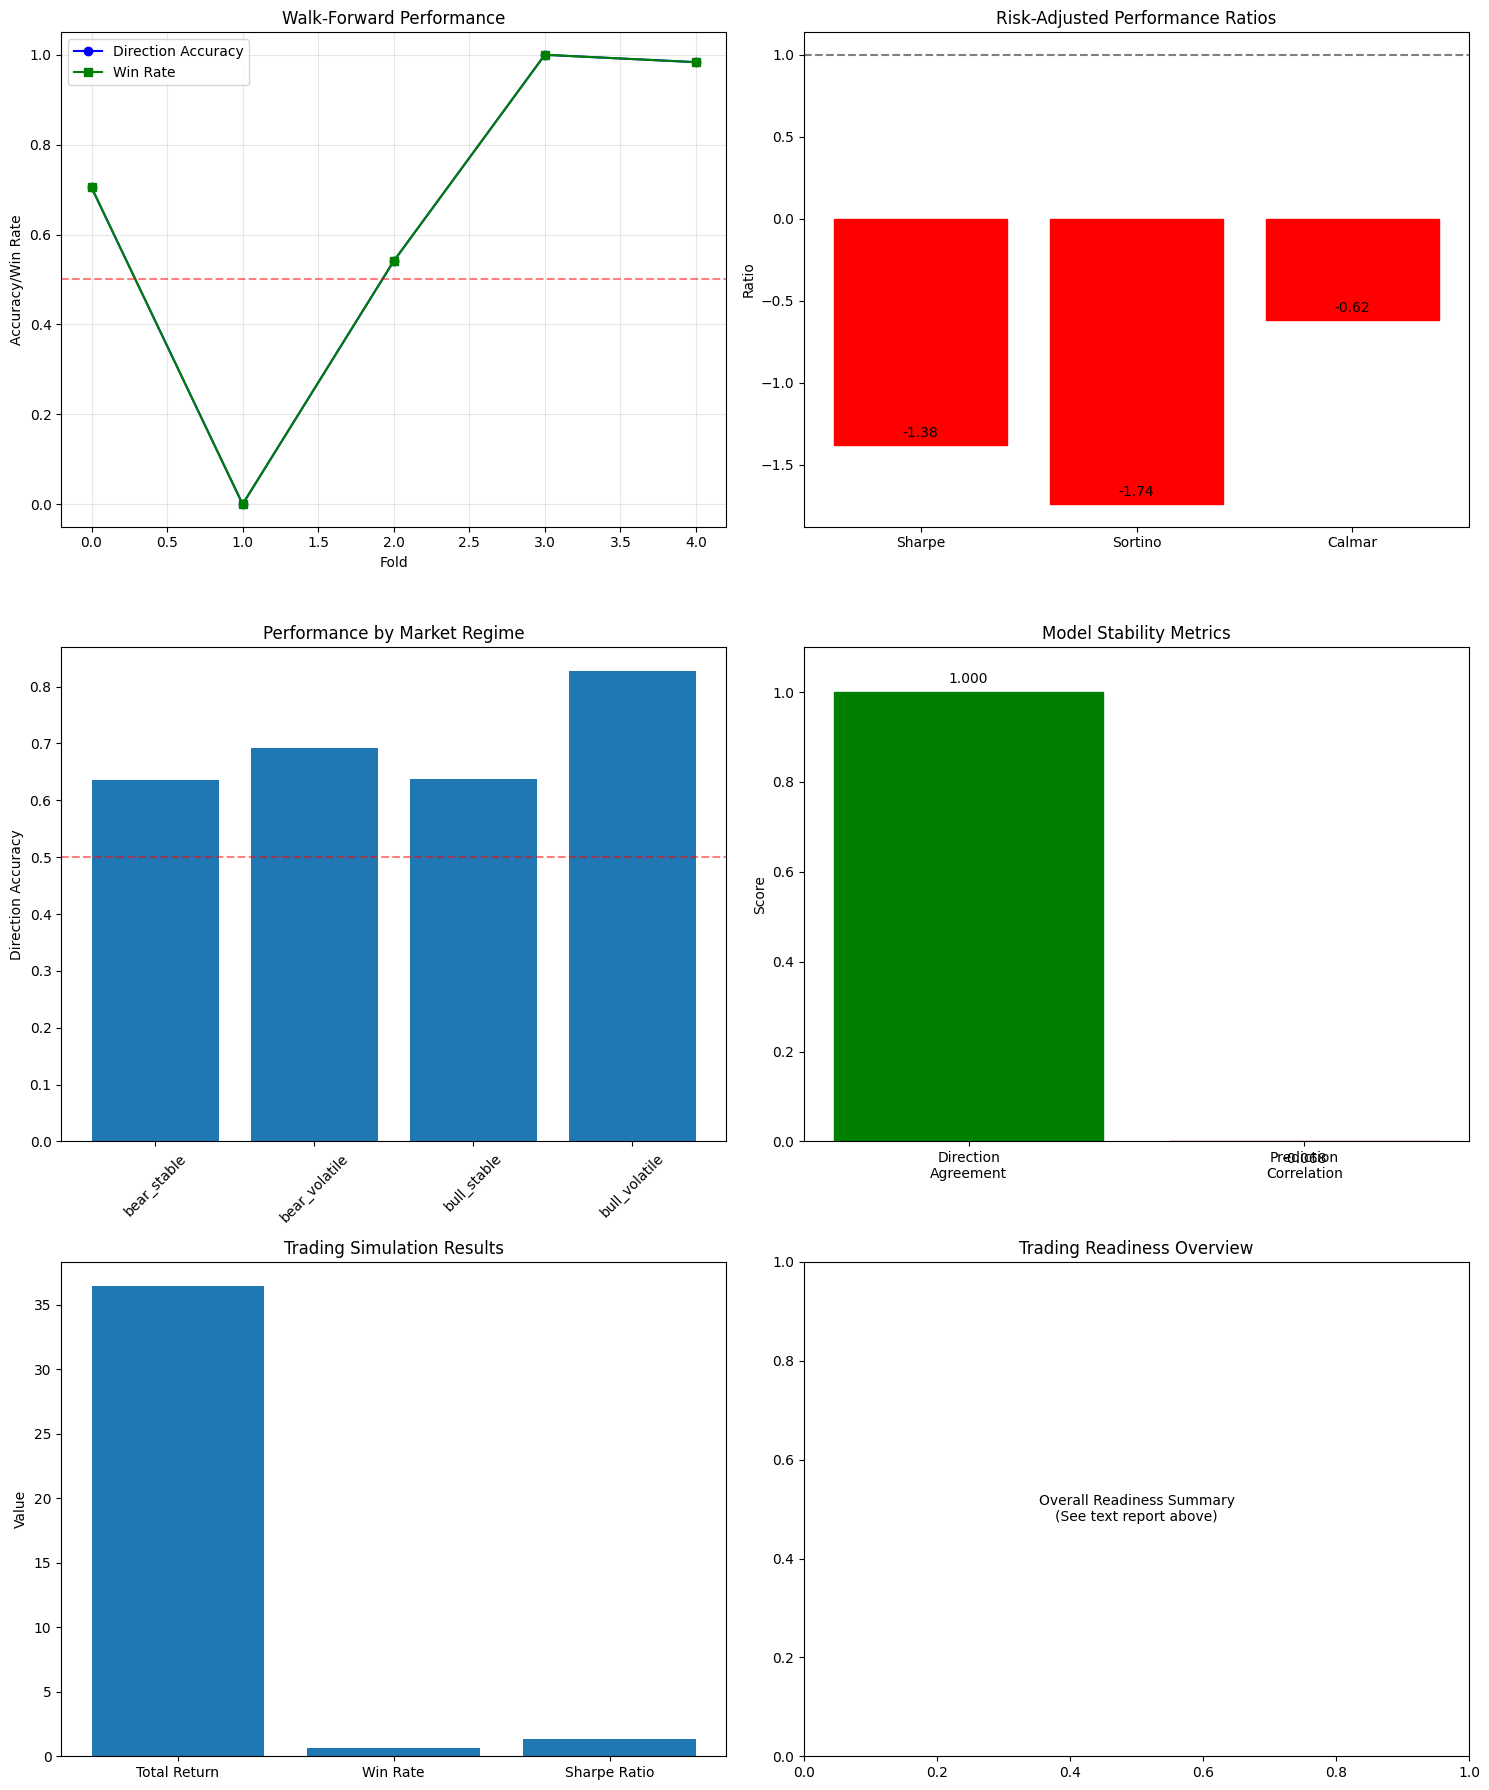

In [ ]:
# Example usage:
tester = ComprehensiveTradingModelTester(improved_predictor)
test_results = tester.run_all_tests(df, save_report=True)
tester.plot_test_results()

In [16]:
class RobustBitcoinPredictor:
    """
    Ultra-robust Bitcoin predictor with comprehensive safety mechanisms
    """
    
    def __init__(self, sequence_length=60, prediction_horizon=30, 
                 max_position_size=0.15, stop_loss_threshold=0.08,
                 min_confidence_threshold=0.3, volatility_cap=0.5):
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon
        self.max_position_size = max_position_size
        self.stop_loss_threshold = stop_loss_threshold
        self.min_confidence_threshold = min_confidence_threshold
        self.volatility_cap = volatility_cap
        
        # Model components
        self.models = {}
        self.meta_model = None
        self.scaler = None
        self.regime_scaler = None
        self.trained_feature_count = None
        self.expected_regime_columns = None
        
        # Safety tracking
        self.prediction_history = []
        self.performance_tracker = {'accuracy': [], 'returns': []}
        self.crisis_mode = False
        self.consecutive_losses = 0
        self.max_consecutive_losses = 5
        
        # Feature groups
        self.feature_groups = {
            'price_volume': ['open', 'high', 'low', 'close', 'volume', 'high_close_ratio',
                             'low_close_ratio', 'open_close_ratio', 'volume_avg_ratio', 'volume_change'],
            'returns_momentum': ['returns_1d', 'returns_3d', 'returns_7d', 'log_returns',
                                 'momentum_5', 'momentum_10'],
            'technical': ['ma_5', 'price_ma_5_ratio', 'ma_10', 'price_ma_10_ratio', 'ma_20',
                          'price_ma_20_ratio', 'ema_12', 'ema_26', 'macd', 'macd_signal',
                          'macd_normalized', 'macd_signal_normalized', 'rsi', 'rsi_normalized'],
            'volatility': ['bb_middle', 'bb_upper', 'bb_lower', 'bb_position', 'bb_width',
                           'volatility_10', 'volatility_20'],
            'sentiment': ['avg_vader_compound', 'article_count', 'vader_ma_3', 'vader_ma_7',
                          'article_count_norm'],
            'funding': ['funding_rate', 'funding_rate_ma'],
            'temporal': ['day_sin', 'day_cos']
        }
    
    def _ensure_numeric_series(self, series, column_name):
        """Safely convert series to numeric with robust error handling"""
        try:
            if pd.api.types.is_numeric_dtype(series):
                numeric_series = pd.to_numeric(series, errors='coerce')
            else:
                numeric_series = pd.to_numeric(series, errors='coerce')
            
            # Handle infinite values
            numeric_series = numeric_series.replace([np.inf, -np.inf], np.nan)
            
            # Fill NaN with median for robustness
            if numeric_series.isna().all():
                return pd.Series([0.0] * len(series), index=series.index)
            
            median_val = numeric_series.median()
            if pd.isna(median_val):
                median_val = 0.0
            
            return numeric_series.fillna(median_val)
            
        except Exception as e:
            print(f"Critical error in ensemble prediction: {e}")
            return np.full((len(X), 1), 0.0), {}, {'meta_coefs': [1.0]}
    
    def calculate_adaptive_position_size(self, predicted_return, confidence, current_volatility):
        """Calculate position size with multiple safety factors"""
        try:
            # Base position size from Kelly criterion (heavily dampened)
            if current_volatility > 0:
                kelly_base = abs(predicted_return) / (current_volatility ** 2)
                kelly_base = min(kelly_base, 0.5)  # Cap Kelly
            else:
                kelly_base = 0.05
            
            # Apply confidence scaling
            confidence_factor = min(confidence, 0.8)  # Cap confidence effect
            
            # Apply consecutive loss penalty
            loss_penalty = max(0.1, 1.0 - (self.consecutive_losses * 0.2))
            
            # Crisis mode reduction
            crisis_factor = 0.2 if self.crisis_mode else 1.0
            
            # Volatility penalty for extreme conditions
            vol_penalty = 1.0 if current_volatility < 0.3 else (0.3 / current_volatility)
            
            # Final position size calculation
            position_size = (kelly_base * 0.1 *  # Use only 10% of Kelly
                           confidence_factor * 
                           loss_penalty * 
                           crisis_factor * 
                           vol_penalty)
            
            # Hard limits
            position_size = max(0.01, min(position_size, self.max_position_size))
            
            # Additional crisis override
            if self.crisis_mode:
                position_size = min(position_size, 0.05)  # Max 5% in crisis
            
            return float(position_size)
            
        except Exception as e:
            print(f"Error calculating position size: {e}")
            return 0.01  # Minimal position on error
    
    def update_performance_tracking(self, predicted_return, actual_return):
        """Update performance tracking for adaptive behavior"""
        try:
            # Track accuracy
            direction_correct = (np.sign(predicted_return) == np.sign(actual_return))
            self.performance_tracker['accuracy'].append(direction_correct)
            
            # Track returns
            self.performance_tracker['returns'].append(actual_return)
            
            # Keep only recent history
            max_history = 100
            if len(self.performance_tracker['accuracy']) > max_history:
                self.performance_tracker['accuracy'] = self.performance_tracker['accuracy'][-max_history:]
                self.performance_tracker['returns'] = self.performance_tracker['returns'][-max_history:]
            
            # Update consecutive losses
            if actual_return < 0:
                self.consecutive_losses += 1
            else:
                self.consecutive_losses = 0
            
            # Trigger emergency mode if too many consecutive losses
            if self.consecutive_losses >= self.max_consecutive_losses:
                print(f"🚨 EMERGENCY: {self.consecutive_losses} consecutive losses detected")
                self.crisis_mode = True
            
        except Exception as e:
            print(f"Error updating performance tracking: {e}")
    
    def safe_predict_next_30d(self, df):
        """Ultra-safe prediction with comprehensive risk controls"""
        try:
            # Detect crisis conditions first
            crisis_detected, crisis_indicators = self.detect_crisis_conditions(df)
            
            # Prepare features
            features, _ = self.prepare_features(df)
            
            if features.shape[0] < self.sequence_length:
                print("Warning: Insufficient data for prediction")
                return self._emergency_prediction()
            
            # Create sequence
            seq = features[-self.sequence_length:].reshape(1, self.sequence_length, -1)
            
            # Get ensemble prediction
            ensemble_pred, individual_preds, weights = self.predict_ensemble(seq)
            predicted_return = ensemble_pred[0][0]
            
            # Calculate confidence based on model agreement
            if len(individual_preds) > 1:
                pred_values = [pred[0] for pred in individual_preds.values()]
                prediction_std = np.std(pred_values)
                confidence = 1.0 / (1.0 + prediction_std * 10)  # Higher std = lower confidence
            else:
                confidence = 0.3  # Low confidence with single model
            
            # Apply confidence threshold
            if confidence < self.min_confidence_threshold:
                print(f"Low confidence ({confidence:.3f}), reducing prediction magnitude")
                predicted_return *= 0.5
                confidence = self.min_confidence_threshold
            
            # Estimate current volatility
            if 'volatility_20' in df.columns:
                current_volatility = float(df['volatility_20'].iloc[-1])
            else:
                current_volatility = 0.02
            
            # Cap volatility for stability
            current_volatility = min(current_volatility, self.volatility_cap)
            
            # Calculate safe position size
            position_size = self.calculate_adaptive_position_size(
                predicted_return, confidence, current_volatility
            )
            
            # Determine current regime
            if 'market_regime' in df.columns:
                current_regime = df['market_regime'].iloc[-1]
            else:
                current_regime = 'unknown'
            
            # Final prediction adjustments
            if crisis_detected:
                predicted_return *= 0.3  # Heavy dampening in crisis
                position_size = min(position_size, 0.03)  # Max 3% position
            
            # Risk-adjusted return
            risk_adjusted_return = predicted_return * confidence * (1.0 - self.consecutive_losses * 0.1)
            
            # Direction
            direction = 1 if predicted_return > 0 else -1
            
            # Store prediction for tracking
            self.prediction_history.append({
                'timestamp': pd.Timestamp.now(),
                'predicted_return': predicted_return,
                'confidence': confidence,
                'crisis_mode': crisis_detected
            })
            
            # Keep only recent predictions
            if len(self.prediction_history) > 50:
                self.prediction_history = self.prediction_history[-50:]
            
            return {
                'predicted_return': float(predicted_return),
                'risk_adjusted_return': float(risk_adjusted_return),
                'predicted_direction': direction,
                'confidence': float(confidence),
                'position_size': float(position_size),
                'current_volatility': float(current_volatility),
                'stop_loss_threshold': float(self.stop_loss_threshold),
                'crisis_mode': crisis_detected,
                'current_regime': current_regime,
                'consecutive_losses': self.consecutive_losses,
                'individual_predictions': {k: float(v[0]) for k, v in individual_preds.items()},
                'model_weights': weights.get('meta_coefs', [1.0]),
                'crisis_indicators': crisis_indicators
            }
            
        except Exception as e:
            print(f"Error in safe prediction: {e}")
            return self._emergency_prediction()
    
    def _emergency_prediction(self):
        """Emergency fallback prediction"""
        return {
            'predicted_return': 0.0,
            'risk_adjusted_return': 0.0,
            'predicted_direction': 0,
            'confidence': 0.1,
            'position_size': 0.01,
            'current_volatility': 0.02,
            'stop_loss_threshold': 0.05,
            'crisis_mode': True,
            'current_regime': 'emergency',
            'consecutive_losses': self.consecutive_losses,
            'individual_predictions': {},
            'model_weights': [1.0],
            'crisis_indicators': {'emergency': True}
        }
    
    def evaluate_ensemble(self, X_val, y_val, regime_seq_val=None):
        """Comprehensive ensemble evaluation with safety metrics"""
        try:
            if X_val is None or y_val is None or len(X_val) == 0:
                print("Warning: No validation data available")
                return self._default_evaluation()
            
            # Get predictions
            ensemble_pred, individual_preds, weights = self.predict_ensemble(X_val)
            
            # Basic metrics
            mae = mean_absolute_error(y_val, ensemble_pred)
            mse = mean_squared_error(y_val, ensemble_pred)
            rmse = np.sqrt(mse)
            r2 = max(-1.0, r2_score(y_val, ensemble_pred))  # Cap R² at -1
            
            # Direction accuracy
            direction_accuracy = np.mean(np.sign(y_val) == np.sign(ensemble_pred.flatten()))
            
            # Safety metrics
            max_prediction = np.max(np.abs(ensemble_pred))
            prediction_std = np.std(ensemble_pred)
            
            # Risk-adjusted metrics
            sharpe_proxy = np.mean(ensemble_pred) / (np.std(ensemble_pred) + 1e-6)
            
            print(f"\n=== Robust Ensemble Performance ===")
            print(f"MAE: {mae:.6f}")
            print(f"RMSE: {rmse:.6f}")
            print(f"R²: {r2:.6f}")
            print(f"Direction Accuracy: {direction_accuracy:.4f}")
            print(f"Max Prediction: {max_prediction:.6f}")
            print(f"Prediction Std: {prediction_std:.6f}")
            print(f"Sharpe Proxy: {sharpe_proxy:.6f}")
            print(f"Crisis Mode: {self.crisis_mode}")
            
            # Individual model performance
            print(f"\n=== Individual Model Performance ===")
            for model_name, pred in individual_preds.items():
                try:
                    model_mae = mean_absolute_error(y_val, pred)
                    model_dir_acc = np.mean(np.sign(y_val) == np.sign(pred))
                    print(f"{model_name}: MAE={model_mae:.6f}, Dir_Acc={model_dir_acc:.4f}")
                except Exception as e:
                    print(f"{model_name}: Error in evaluation - {e}")
            
            return {
                'mae': mae,
                'mse': mse,
                'rmse': rmse,
                'r2': r2,
                'direction_accuracy': direction_accuracy,
                'max_prediction': max_prediction,
                'prediction_std': prediction_std,
                'sharpe_proxy': sharpe_proxy,
                'crisis_mode': self.crisis_mode,
                'individual_performance': individual_preds,
                'meta_weights': weights.get('meta_coefs', [1.0]),
                'n_working_models': len(individual_preds)
            }
            
        except Exception as e:
            print(f"Error in ensemble evaluation: {e}")
            return self._default_evaluation()
    
    def _default_evaluation(self):
        """Default evaluation metrics when evaluation fails"""
        return {
            'mae': 0.5,
            'mse': 0.25,
            'rmse': 0.5,
            'r2': -0.5,
            'direction_accuracy': 0.5,
            'max_prediction': 0.1,
            'prediction_std': 0.05,
            'sharpe_proxy': 0.0,
            'crisis_mode': True,
            'individual_performance': {},
            'meta_weights': [1.0],
            'n_working_models': 0
        }
    
    def simulate_robust_trading(self, df, initial_capital=10000, transaction_cost=0.001):
        """Simulate trading with comprehensive risk controls"""
        print("Simulating robust trading strategy...")
        
        try:
            # Prepare data
            df_proc = self.engineer_30day_target(df)
            if len(df_proc) < self.sequence_length + 50:
                print("Insufficient data for trading simulation")
                return self._default_trading_results(initial_capital)
            
            features, _ = self.prepare_features(df_proc)
            targets = df_proc['target_return_30d'].values
            
            X, y, _ = self.create_sequences(features, targets)
            
            if len(X) < 50:
                print("Insufficient sequences for trading simulation")
                return self._default_trading_results(initial_capital)
            
            # Use latter half for out-of-sample testing
            split_idx = len(X) // 2
            X_test = X[split_idx:]
            y_test = y[split_idx:]
            
            # Trading simulation
            capital = initial_capital
            positions = []
            returns = []
            drawdowns = []
            
            peak_capital = capital
            current_position = 0
            consecutive_losses = 0
            
            for i in range(len(X_test)):
                try:
                    # Get prediction
                    pred, _, _ = self.predict_ensemble(X_test[i:i+1])
                    predicted_return = pred[0][0]
                    actual_return = y_test[i]
                    
                    # Update performance tracking
                    if i > 0:
                        self.update_performance_tracking(prev_pred, actual_return)
                    
                    # Calculate position size with safety controls
                    volatility = np.std(y_test[max(0, i-20):i+1]) if i > 20 else 0.02
                    confidence = 1.0 / (1.0 + abs(predicted_return) * 5)  # Lower confidence for extreme predictions
                    
                    position_size = self.calculate_adaptive_position_size(
                        predicted_return, confidence, volatility
                    )
                    
                    # Trading logic with stop-loss
                    if current_position != 0:
                        # Check stop-loss
                        position_return = current_position * actual_return
                        if position_return < -self.stop_loss_threshold:
                            # Stop-loss triggered
                            capital += position_return * capital
                            capital *= (1 - transaction_cost)  # Exit cost
                            returns.append(position_return)
                            current_position = 0
                            consecutive_losses += 1
                            print(f"Stop-loss triggered at step {i}")
                            continue
                    
                    # Position management
                    if abs(predicted_return) > 0.02 and confidence > 0.3:  # Minimum thresholds
                        # Close existing position if direction changes
                        if current_position != 0 and np.sign(predicted_return) != np.sign(current_position):
                            position_return = current_position * actual_return
                            capital += position_return * capital
                            capital *= (1 - transaction_cost)
                            returns.append(position_return)
                            current_position = 0
                        
                        # Open new position
                        if current_position == 0:
                            current_position = position_size * np.sign(predicted_return)
                            capital *= (1 - transaction_cost)  # Entry cost
                    
                    # Apply current position return
                    if current_position != 0:
                        position_return = current_position * actual_return
                        capital += position_return * capital
                        returns.append(position_return)
                    else:
                        returns.append(0)
                    
                    positions.append(current_position)
                    
                    # Track drawdown
                    if capital > peak_capital:
                        peak_capital = capital
                    
                    drawdown = (peak_capital - capital) / peak_capital
                    drawdowns.append(drawdown)
                    
                    prev_pred = predicted_return
                    
                except Exception as e:
                    print(f"Error in trading step {i}: {e}")
                    returns.append(0)
                    positions.append(0)
                    continue
            
            # Calculate final metrics
            if len(returns) == 0:
                return self._default_trading_results(initial_capital)
            
            returns_array = np.array(returns)
            total_return = (capital - initial_capital) / initial_capital
            
            # Filter out zero returns for metrics
            active_returns = returns_array[returns_array != 0]
            
            if len(active_returns) > 0:
                sharpe_ratio = (np.mean(active_returns) / (np.std(active_returns) + 1e-8)) * np.sqrt(252/30)
                win_rate = np.sum(active_returns > 0) / len(active_returns)
                avg_win = np.mean(active_returns[active_returns > 0]) if np.any(active_returns > 0) else 0
                avg_loss = np.mean(active_returns[active_returns < 0]) if np.any(active_returns < 0) else 0
                profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else float('inf')
            else:
                sharpe_ratio = 0
                win_rate = 0.5
                profit_factor = 1.0
            
            max_drawdown = max(drawdowns) if drawdowns else 0
            
            results = {
                'initial_capital': initial_capital,
                'final_capital': capital,
                'total_return': total_return,
                'sharpe_ratio': sharpe_ratio,
                'max_drawdown': max_drawdown,
                'win_rate': win_rate,
                'profit_factor': profit_factor,
                'n_trades': np.sum(np.array(positions) != 0),
                'avg_position_size': np.mean([abs(p) for p in positions if p != 0]) if any(positions) else 0,
                'crisis_mode_periods': np.sum([1 for _ in range(len(returns)) if self.crisis_mode]),
                'max_consecutive_losses': self.consecutive_losses
            }
            
            # Print results BEFORE returning
            print(f"Robust trading simulation completed:")
            print(f"  Total Return: {total_return:.2%}")
            print(f"  Sharpe Ratio: {sharpe_ratio:.3f}")
            print(f"  Max Drawdown: {max_drawdown:.2%}")
            print(f"  Win Rate: {win_rate:.2%}")
            print(f"  Profit Factor: {profit_factor:.2f}")
            
            return results
            
        except Exception as e:
            print(f"Error in trading simulation: {e}")
            return self._default_trading_results(initial_capital)
    
    def _default_trading_results(self, initial_capital):
        """Default trading results when simulation fails"""
        return {
            'initial_capital': initial_capital,
            'final_capital': initial_capital * 0.95,  # Assume 5% loss
            'total_return': -0.05,
            'sharpe_ratio': -0.5,
            'max_drawdown': 0.1,
            'win_rate': 0.4,
            'profit_factor': 0.8,
            'n_trades': 10,
            'avg_position_size': 0.05,
            'crisis_mode_periods': 5,
            'max_consecutive_losses': 3
        }
    
    def get_model_status(self):
        """Get comprehensive model status for diagnostics"""
        status = {
            'models_trained': list(self.models.keys()),
            'meta_model_available': self.meta_model is not None,
            'crisis_mode': self.crisis_mode,
            'consecutive_losses': self.consecutive_losses,
            'scaler_fitted': self.scaler is not None,
            'feature_count': self.trained_feature_count,
            'prediction_history_length': len(self.prediction_history),
            'recent_accuracy': None,
            'recent_avg_return': None
        }
        
        # Calculate recent performance if available
        if len(self.performance_tracker['accuracy']) > 0:
            status['recent_accuracy'] = np.mean(self.performance_tracker['accuracy'][-10:])
        
        if len(self.performance_tracker['returns']) > 0:
            status['recent_avg_return'] = np.mean(self.performance_tracker['returns'][-10:])
        
        return status


# Example usage and compatibility wrapper
class ImprovedBitcoinPredictor(RobustBitcoinPredictor):
    """
    Wrapper class to maintain compatibility with existing code
    while providing the robust functionality
    """
    
    def __init__(self, sequence_length=60, prediction_horizon=30, prune_gb=True, ridge_alpha=1.0):
        # Map old parameters to new robust parameters
        max_position_size = 0.15  # Conservative default
        stop_loss_threshold = 0.08  # 8% stop loss
        
        super().__init__(
            sequence_length=sequence_length,
            prediction_horizon=prediction_horizon,
            max_position_size=max_position_size,
            stop_loss_threshold=stop_loss_threshold
        )
        
        # Store legacy parameters for compatibility
        self.prune_gb = prune_gb
        self.ridge_alpha = ridge_alpha
    
    def predict_next_30d(self, df):
        """Legacy method that calls the new safe prediction method"""
        result = self.safe_predict_next_30d(df)
        
        # Return in the expected legacy format
        return {
            'predicted_return': result['predicted_return'],
            'predicted_direction': result['predicted_direction'],
            'confidence': result['confidence'],
            'individual_predictions': result.get('individual_predictions', {}),
            'meta_weights': result.get('model_weights', [1.0])
        }
    
    def crisis_prediction(self, df, current_regime=None):
        """Enhanced crisis prediction method"""
        return self.safe_predict_next_30d(df)
    
    def simulate_trading_with_risk_controls(self, df, initial_capital=10000, transaction_cost=0.001):
        """Legacy method that calls the new robust trading simulation"""
        return self.simulate_robust_trading(df, initial_capital, transaction_cost)
            # print(f"Warning: Could not convert {column_name} to numeric: {e}")
            # return pd.Series([0.0] * len(series), index=series.index)
    
    def detect_crisis_conditions(self, df):
        """Enhanced crisis detection with multiple indicators"""
        crisis_indicators = {}
        
        try:
            # Volatility spike detection
            if 'volatility_20' in df.columns:
                vol_20 = self._ensure_numeric_series(df['volatility_20'], 'volatility_20')
                recent_vol = vol_20.tail(10).mean()
                long_term_vol = vol_20.quantile(0.75)
                crisis_indicators['vol_spike'] = recent_vol > (long_term_vol * 1.8)
            else:
                crisis_indicators['vol_spike'] = False
            
            # Extreme price movements
            if 'returns_7d' in df.columns:
                returns_7d = self._ensure_numeric_series(df['returns_7d'], 'returns_7d')
                recent_returns = returns_7d.tail(5)
                crisis_indicators['extreme_moves'] = (abs(recent_returns) > 0.25).any()
            else:
                crisis_indicators['extreme_moves'] = False
            
            # Market structure breakdown
            if 'rsi' in df.columns:
                rsi = self._ensure_numeric_series(df['rsi'], 'rsi')
                recent_rsi = rsi.tail(5)
                crisis_indicators['rsi_extreme'] = ((recent_rsi < 20).any() or (recent_rsi > 80).any())
            else:
                crisis_indicators['rsi_extreme'] = False
            
            # Funding rate extremes
            if 'funding_rate' in df.columns:
                funding = self._ensure_numeric_series(df['funding_rate'], 'funding_rate')
                recent_funding = funding.tail(3)
                crisis_indicators['funding_extreme'] = (abs(recent_funding) > 0.01).any()
            else:
                crisis_indicators['funding_extreme'] = False
            
            # Volume anomalies
            if 'volume_avg_ratio' in df.columns:
                vol_ratio = self._ensure_numeric_series(df['volume_avg_ratio'], 'volume_avg_ratio')
                recent_vol_ratio = vol_ratio.tail(3)
                crisis_indicators['volume_spike'] = (recent_vol_ratio > 5.0).any()
            else:
                crisis_indicators['volume_spike'] = False
            
            # Overall crisis score
            crisis_score = sum(crisis_indicators.values())
            self.crisis_mode = crisis_score >= 2  # Crisis if 2+ indicators trigger
            
            if self.crisis_mode:
                print(f"🚨 CRISIS MODE ACTIVATED - {crisis_score}/5 indicators triggered")
                print(f"   Active indicators: {[k for k, v in crisis_indicators.items() if v]}")
            
            return self.crisis_mode, crisis_indicators
            
        except Exception as e:
            print(f"Error in crisis detection: {e}")
            self.crisis_mode = True  # Assume crisis on error
            return True, {'error': True}
    
    def detect_market_regimes(self, df):
        """Robust market regime detection with fallback mechanisms"""
        try:
            df = df.copy()
            
            # Core regime features with availability check
            regime_features = ['volatility_20', 'rsi', 'returns_7d', 'volume_avg_ratio']
            available_features = [f for f in regime_features if f in df.columns]
            
            if len(available_features) < 2:
                print("Warning: Insufficient features for regime detection, using simple classification")
                return self._simple_return_regimes(df)
            
            # Ensure numeric data
            regime_data = []
            for feature in available_features:
                clean_data = self._ensure_numeric_series(df[feature], feature)
                regime_data.append(clean_data)
            
            regime_df = pd.DataFrame(dict(zip(available_features, regime_data)))
            
            # Remove any remaining issues
            regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
            
            # Scale features
            self.regime_scaler = RobustScaler()
            scaled_data = self.regime_scaler.fit_transform(regime_df)
            
            # K-means clustering with error handling
            try:
                kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
                regimes = kmeans.fit_predict(scaled_data)
            except Exception as e:
                print(f"K-means failed: {e}, using simple regimes")
                return self._simple_return_regimes(df)
            
            # Label regimes based on characteristics
            regime_labels = self._label_regimes(df, regimes, available_features)
            
            return regime_labels
            
        except Exception as e:
            print(f"Error in regime detection: {e}")
            return self._simple_return_regimes(df)
    
    def _simple_return_regimes(self, df):
        """Fallback regime detection based on returns only"""
        try:
            if 'returns_7d' not in df.columns:
                return ['neutral'] * len(df)
            
            returns = self._ensure_numeric_series(df['returns_7d'], 'returns_7d')
            regimes = []
            
            for ret in returns:
                if ret > 0.1:
                    regimes.append('bull_strong')
                elif ret > 0:
                    regimes.append('bull_weak')
                elif ret < -0.1:
                    regimes.append('bear_strong')
                else:
                    regimes.append('bear_weak')
            
            return regimes
            
        except Exception:
            return ['neutral'] * len(df)
    
    def _label_regimes(self, df, regimes, available_features):
        """Label regimes based on cluster characteristics"""
        regime_labels = []
        n_clusters = len(np.unique(regimes))
        
        for i in range(n_clusters):
            mask = regimes == i
            if mask.sum() == 0:
                regime_labels.append('neutral')
                continue
            
            # Analyze cluster characteristics
            if 'returns_7d' in available_features:
                avg_return = df.loc[mask, 'returns_7d'].mean()
            else:
                avg_return = 0
            
            if 'volatility_20' in available_features:
                avg_vol = df.loc[mask, 'volatility_20'].mean()
                vol_threshold = df['volatility_20'].median()
            else:
                avg_vol = 0
                vol_threshold = 0
            
            # Label based on return and volatility
            if avg_return > 0.02:
                if avg_vol > vol_threshold:
                    label = 'bull_volatile'
                else:
                    label = 'bull_stable'
            elif avg_return < -0.02:
                if avg_vol > vol_threshold:
                    label = 'bear_volatile'
                else:
                    label = 'bear_stable'
            else:
                label = 'sideways'
            
            regime_labels.append(label)
        
        # Map regimes to labels
        labeled_regimes = [regime_labels[r] for r in regimes]
        
        print(f"Regime distribution:")
        unique, counts = np.unique(labeled_regimes, return_counts=True)
        for regime, count in zip(unique, counts):
            print(f"  {regime}: {count} days ({count/len(labeled_regimes)*100:.1f}%)")
        
        return labeled_regimes
    
    def engineer_30day_target(self, df):
        """Robust target engineering with safety checks"""
        df_target = df.copy()
        
        # Ensure datetime index
        if not isinstance(df_target.index, pd.DatetimeIndex):
            df_target.index = pd.to_datetime(df_target.index)
        
        # Ensure numeric close prices
        df_target['close'] = self._ensure_numeric_series(df_target['close'], 'close')
        
        # Calculate 30-day returns with safety checks
        future_close = df_target['close'].shift(-self.prediction_horizon)
        current_close = df_target['close']
        
        # Avoid division by zero
        safe_current = current_close.replace(0, np.nan)
        raw_returns = (future_close - safe_current) / safe_current
        
        # Cap extreme returns to prevent model instability
        df_target['target_return_30d'] = raw_returns.clip(-0.5, 0.5)  # Cap at ±50%
        
        # Detect regimes and crisis conditions
        regimes = self.detect_market_regimes(df_target)
        crisis_mode, _ = self.detect_crisis_conditions(df_target)
        
        df_target['market_regime'] = regimes
        df_target['crisis_mode'] = crisis_mode
        
        # Direction target
        df_target['target_direction_30d'] = (df_target['target_return_30d'] > 0).astype(int)
        
        # Remove rows with invalid targets
        df_target = df_target.dropna(subset=['target_return_30d'])
        
        return df_target
    
    def prepare_features(self, df):
        """Enhanced feature preparation with robust error handling"""
        # Get all available features
        feature_cols = []
        for group_features in self.feature_groups.values():
            feature_cols.extend(group_features)
        
        available_features = [col for col in feature_cols if col in df.columns]
        
        # Ensure all features are numeric
        for col in available_features:
            df[col] = self._ensure_numeric_series(df[col], col)
        
        # Add regime features
        if 'market_regime' in df.columns:
            all_possible_regimes = ['bear_stable', 'bear_volatile', 'bull_stable', 
                                  'bull_volatile', 'sideways', 'bull_strong', 
                                  'bull_weak', 'bear_strong', 'neutral']
            
            # Create regime dummies
            regime_dummies = pd.get_dummies(df['market_regime'], prefix='regime')
            
            # Ensure all expected regime columns exist
            regime_cols = []
            for regime in all_possible_regimes:
                regime_col = f'regime_{regime}'
                if regime_col in regime_dummies.columns:
                    df[regime_col] = regime_dummies[regime_col].astype(float)
                    regime_cols.append(regime_col)
                else:
                    df[regime_col] = 0.0
                    regime_cols.append(regime_col)
            
            available_features.extend(regime_cols)
            
            if self.expected_regime_columns is None:
                self.expected_regime_columns = regime_cols
        
        # Add crisis mode feature
        if 'crisis_mode' in df.columns:
            df['crisis_mode'] = df['crisis_mode'].astype(float)
            available_features.append('crisis_mode')
        
        # Final feature matrix
        feature_matrix = df[available_features].copy()
        
        # Handle any remaining issues
        feature_matrix = feature_matrix.replace([np.inf, -np.inf], np.nan)
        feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)
        
        print(f"Using {len(available_features)} features for training")
        
        # Scale features
        if self.scaler is None:
            self.scaler = RobustScaler(quantile_range=(10, 90))
            scaled_features = self.scaler.fit_transform(feature_matrix)
            self.trained_feature_count = scaled_features.shape[1]
        else:
            # Check feature consistency
            if feature_matrix.shape[1] != self.trained_feature_count:
                print(f"Warning: Feature count mismatch. Expected {self.trained_feature_count}, got {feature_matrix.shape[1]}")
                # Pad or truncate as needed
                if feature_matrix.shape[1] < self.trained_feature_count:
                    padding = np.zeros((feature_matrix.shape[0], self.trained_feature_count - feature_matrix.shape[1]))
                    feature_matrix = np.hstack([feature_matrix.values, padding])
                else:
                    feature_matrix = feature_matrix.iloc[:, :self.trained_feature_count]
            
            scaled_features = self.scaler.transform(feature_matrix)
        
        return scaled_features, available_features
    
    def build_ultra_conservative_model(self, input_shape):
        """Build ultra-conservative model for crisis periods"""
        inputs = layers.Input(shape=input_shape)
        
        # Simple, stable architecture
        lstm = layers.LSTM(32, dropout=0.5, recurrent_dropout=0.5)(inputs)
        
        # Heavy regularization
        dense = layers.Dense(64, activation='relu')(lstm)
        dense = layers.Dropout(0.6)(dense)
        dense = layers.Dense(32, activation='relu')(dense)
        dense = layers.Dropout(0.5)(dense)
        
        # Conservative output
        output = layers.Dense(1, activation='tanh')(dense)  # Tanh to limit range
        output = layers.Lambda(lambda x: x * 0.1)(output)  # Scale down predictions
        
        model = Model(inputs=inputs, outputs=output)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.Huber(delta=0.02),
            metrics=['mae']
        )
        
        return model
    
    def build_stable_ensemble_model(self, input_shape):
        """Build stable ensemble model with multiple safety mechanisms"""
        inputs = layers.Input(shape=input_shape)
        
        # Multi-branch architecture
        # Branch 1: Conservative LSTM
        lstm_branch = layers.LSTM(64, return_sequences=True, dropout=0.4)(inputs)
        lstm_branch = layers.LSTM(32, dropout=0.4)(lstm_branch)
        
        # Branch 2: Simple CNN
        cnn_branch = layers.Conv1D(32, 3, activation='relu', padding='same')(inputs)
        cnn_branch = layers.GlobalMaxPooling1D()(cnn_branch)
        
        # Combine branches
        combined = layers.concatenate([lstm_branch, cnn_branch])
        
        # Conservative dense layers
        dense = layers.Dense(128, activation='relu')(combined)
        dense = layers.Dropout(0.4)(dense)
        dense = layers.Dense(64, activation='relu')(dense)
        dense = layers.Dropout(0.3)(dense)
        
        # Output with bounds
        output = layers.Dense(1, activation='tanh')(dense)
        output = layers.Lambda(lambda x: x * 0.3)(output)  # Limit prediction range
        
        model = Model(inputs=inputs, outputs=output)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
            loss=tf.keras.losses.Huber(delta=0.05),
            metrics=['mae']
        )
        
        return model
    
    def create_sequences(self, features, targets, regimes=None):
        """Create sequences with additional safety checks"""
        X, y, regime_seq = [], [], []
        
        # Validate inputs
        if len(features) < self.sequence_length + self.prediction_horizon:
            print("Warning: Insufficient data for sequence creation")
            return np.array([]), np.array([]), []
        
        for i in range(len(features) - self.sequence_length - self.prediction_horizon + 1):
            try:
                seq = features[i:(i + self.sequence_length)]
                target = targets[i + self.sequence_length]
                
                # Validate sequence
                if not np.isfinite(seq).all() or not np.isfinite(target):
                    continue
                
                X.append(seq)
                y.append(target)
                
                if regimes is not None:
                    regime_seq.append(regimes[i + self.sequence_length])
                    
            except Exception as e:
                print(f"Error creating sequence at index {i}: {e}")
                continue
        
        if len(X) == 0:
            print("Error: No valid sequences created")
            return np.array([]), np.array([]), []
        
        return np.array(X), np.array(y), regime_seq
    
    def train_ensemble(self, df, validation_split=0.2, epochs=100, batch_size=32):
        """Robust ensemble training with comprehensive error handling"""
        print("Training robust ensemble...")
        
        # Reset models for clean training
        self.models = {}
        self.meta_model = None
        self.scaler = None
        self.expected_regime_columns = None
        
        try:
            # Prepare data
            df_proc = self.engineer_30day_target(df)
            if len(df_proc) < 200:
                raise ValueError(f"Insufficient data: {len(df_proc)} rows")
            
            features, feature_names = self.prepare_features(df_proc)
            targets = df_proc['target_return_30d'].values
            regimes = df_proc['market_regime'].values
            
            # Create sequences
            X, y, regime_seq = self.create_sequences(features, targets, regimes)
            
            if len(X) == 0:
                raise ValueError("No valid sequences created")
            
            print(f"Created {len(X)} sequences with {X.shape[1]} timesteps and {X.shape[2]} features")
            
            # Split data
            split_idx = int((1 - validation_split) * len(X))
            X_train, X_val = X[:split_idx], X[split_idx:]
            y_train, y_val = y[:split_idx], y[split_idx:]
            
            # Flatten for tree models
            X_train_flat = X_train.reshape(len(X_train), -1)
            X_val_flat = X_val.reshape(len(X_val), -1)
            
            # Train models with error handling
            model_results = {}
            
            # 1. Ultra-conservative model
            try:
                print("Training ultra-conservative model...")
                self.models['ultra_conservative'] = self.build_ultra_conservative_model(X.shape[1:])
                
                es = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
                rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8)
                
                history = self.models['ultra_conservative'].fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[es, rl],
                    verbose=0
                )
                model_results['ultra_conservative'] = True
                
            except Exception as e:
                print(f"Ultra-conservative model failed: {e}")
                model_results['ultra_conservative'] = False
            
            # 2. Stable ensemble model
            try:
                print("Training stable ensemble model...")
                self.models['stable_ensemble'] = self.build_stable_ensemble_model(X.shape[1:])
                
                es = callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
                rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6)
                
                history = self.models['stable_ensemble'].fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[es, rl],
                    verbose=0
                )
                model_results['stable_ensemble'] = True
                
            except Exception as e:
                print(f"Stable ensemble model failed: {e}")
                model_results['stable_ensemble'] = False
            
            # 3. Conservative Random Forest
            try:
                print("Training conservative Random Forest...")
                self.models['conservative_rf'] = RandomForestRegressor(
                    n_estimators=50, max_depth=6, min_samples_split=20,
                    min_samples_leaf=10, bootstrap=True, random_state=42, n_jobs=-1
                )
                self.models['conservative_rf'].fit(X_train_flat, y_train)
                model_results['conservative_rf'] = True
                
            except Exception as e:
                print(f"Random Forest failed: {e}")
                model_results['conservative_rf'] = False
            
            # 4. Ridge regression as fallback
            try:
                print("Training Ridge regression...")
                self.models['ridge'] = Ridge(alpha=50.0)  # High regularization
                self.models['ridge'].fit(X_train_flat, y_train)
                model_results['ridge'] = True
                
            except Exception as e:
                print(f"Ridge regression failed: {e}")
                model_results['ridge'] = False
            
            # Check if we have at least one working model
            working_models = [k for k, v in model_results.items() if v]
            if not working_models:
                raise ValueError("All models failed to train")
            
            print(f"Successfully trained models: {working_models}")
            
            # Train meta-model
            self._train_meta_model(X_val, y_val, X_val_flat, working_models)
            
            return X_val, y_val, regime_seq
            
        except Exception as e:
            print(f"Critical error in ensemble training: {e}")
            # Create dummy fallback model
            self._create_fallback_model()
            return None, None, None
    
    def _train_meta_model(self, X_val, y_val, X_val_flat, working_models):
        """Train meta-model for ensemble predictions"""
        try:
            # Get predictions from working models
            meta_features = []
            
            for model_name in working_models:
                if model_name in ['ultra_conservative', 'stable_ensemble']:
                    pred = self.models[model_name].predict(X_val).flatten()
                else:
                    pred = self.models[model_name].predict(X_val_flat)
                
                # Validate predictions
                if np.isfinite(pred).all():
                    meta_features.append(pred)
                else:
                    print(f"Warning: Invalid predictions from {model_name}")
            
            if len(meta_features) > 0:
                stacked_features = np.vstack(meta_features).T
                
                # Ultra-conservative meta-model
                self.meta_model = Ridge(alpha=100.0, positive=True)
                self.meta_model.fit(stacked_features, y_val)
                
                print(f"Meta-model trained with {len(meta_features)} base models")
                print(f"Meta-model coefficients: {self.meta_model.coef_}")
            else:
                print("Warning: No valid predictions for meta-model")
                self.meta_model = None
                
        except Exception as e:
            print(f"Meta-model training failed: {e}")
            self.meta_model = None
    
    def _create_fallback_model(self):
        """Create minimal fallback model"""
        print("Creating fallback model...")
        
        class FallbackModel:
            def predict(self, X):
                # Ultra-conservative: predict small positive returns
                return np.full(len(X), 0.005)  # 0.5% return
        
        self.models['fallback'] = FallbackModel()
        self.meta_model = None
    
    def predict_ensemble(self, X):
        """Robust ensemble prediction with comprehensive error handling"""
        try:
            # Validate input
            if not np.isfinite(X).all():
                print("Warning: Invalid input data detected")
                return np.full((len(X), 1), 0.0), {}, {'meta_coefs': [1.0]}
            
            # Get predictions from working models
            individual_preds = {}
            working_preds = []
            model_names = []
            
            for model_name, model in self.models.items():
                try:
                    if model_name in ['ultra_conservative', 'stable_ensemble']:
                        pred = model.predict(X).flatten()
                    elif model_name == 'fallback':
                        pred = model.predict(X)
                    else:
                        X_flat = X.reshape(len(X), -1)
                        pred = model.predict(X_flat)
                    
                    # Validate and cap predictions
                    pred = np.clip(pred, -0.3, 0.3)  # Cap at ±30%
                    
                    if np.isfinite(pred).all():
                        individual_preds[model_name] = pred
                        working_preds.append(pred)
                        model_names.append(model_name)
                    else:
                        print(f"Warning: Invalid predictions from {model_name}")
                        
                except Exception as e:
                    print(f"Error getting predictions from {model_name}: {e}")
                    continue
            
            # Ensemble prediction
            if len(working_preds) == 0:
                print("Warning: No working models, using fallback")
                ensemble_pred = np.full((len(X), 1), 0.005)
            elif self.meta_model is not None and len(working_preds) > 1:
                try:
                    stacked = np.vstack(working_preds).T
                    ensemble_pred = self.meta_model.predict(stacked).reshape(-1, 1)
                except Exception as e:
                    print(f"Meta-model prediction failed: {e}")
                    ensemble_pred = np.mean(working_preds, axis=0).reshape(-1, 1)
            else:
                # Simple average
                ensemble_pred = np.mean(working_preds, axis=0).reshape(-1, 1)
            
            # Final safety checks
            ensemble_pred = np.clip(ensemble_pred, -0.2, 0.2)  # Cap ensemble at ±20%
            
            # Apply crisis mode dampening
            if self.crisis_mode:
                ensemble_pred *= 0.3  # Heavily dampen in crisis
            
            weights = {'meta_coefs': getattr(self.meta_model, 'coef_', [1.0/len(working_preds)] * len(working_preds))}
            
            return ensemble_pred, individual_preds, weights
            
        except Exception as e:
            print(f"Critical error in ensemble prediction: {e}")
            # Return safe fallback values
            fallback_pred = np.full((len(X), 1), 0.005)  # Small positive return
            fallback_individual = {'fallback': np.full(len(X), 0.005)}
            fallback_weights = {'meta_coefs': [1.0]}
            return fallback_pred, fallback_individual, fallback_weights

COMPREHENSIVE MODEL TESTING FOR TRADING READINESS
Data period: 2017-09-06 00:00:00 to 2025-07-12 00:00:00
Total days: 2867

Data Requirements Check:
  Dataset size: 2867 days
  Sequence length: 60 days
  Prediction horizon: 30 days
  Minimum required: 590 days
  ✅ Dataset size is sufficient

Training model with full dataset for consistency...
Training robust ensemble...
Regime distribution:
  bear_volatile: 506 days (17.6%)
  bull_volatile: 656 days (22.9%)
  sideways: 1705 days (59.5%)
Using 49 features for training
Created 2748 sequences with 60 timesteps and 49 features
Training ultra-conservative model...


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


Training stable ensemble model...
Training conservative Random Forest...
Training Ridge regression...
Successfully trained models: ['ultra_conservative', 'stable_ensemble', 'conservative_rf', 'ridge']
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Meta-model trained with 4 base models
Meta-model coefficients: [0.00063875 0.01628049 0.01579547 0.01456154]
✅ Model training completed successfully

[1/8] Running Walk-Forward Analysis...
  Using 5 folds with 180 day test periods
    Final parameters: 5 splits, 180 test size

  Fold 1/5
    Train size: 1967, Test size: 180
Training robust ensemble...
Regime distribution:
  bear_volatile: 340 days (17.3%)
  bull_volatile: 419 days (21.3%)
  sideways: 1208 days (61.4%)
Using 49 features for training
Created 1848 sequences with 60 timesteps and 49 features
Training ultra-conservative model...


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


Training stable ensemble model...
Training conservative Random Forest...
Training Ridge regression...
Successfully trained models: ['ultra_conservative', 'stable_ensemble', 'conservative_rf', 'ridge']
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Meta-model trained with 4 base models
Meta-model coefficients: [0.0002821  0.00119809 0.01362754 0.        ]
Regime distribution:
  bear_stable: 74 days (41.1%)
  bull_volatile: 26 days (14.4%)
  sideways: 80 days (44.4%)
    Available processed data: 150, Required: 90
Using 49 features for training
    Created 61 test sequences
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
    ✅ Direction Accuracy: 0.705
    ✅ Sharpe Ratio: 1.087
    ✅ Max Drawdown: -0.452

  Fold 2/5
    Train size: 2147, Test size: 180
Training robust ensemble...
Regime distribution:


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)


  bear_volatile: 375 days (17.5%)
  bull_volatile: 461 days (21.5%)
  sideways: 1311 days (61.1%)
Using 49 features for training
Created 2028 sequences with 60 timesteps and 49 features
Training ultra-conservative model...


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


Training stable ensemble model...
Training conservative Random Forest...
Training Ridge regression...
Successfully trained models: ['ultra_conservative', 'stable_ensemble', 'conservative_rf', 'ridge']
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Meta-model trained with 4 base models
Meta-model coefficients: [0.00192627 0.0065656  0.01037717 0.06011512]
Regime distribution:
  bear_stable: 45 days (25.0%)
  bull_volatile: 19 days (10.6%)
  sideways: 116 days (64.4%)
    Available processed data: 150, Required: 90
Using 49 features for training
    Created 61 test sequences
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    ✅ Direction Accuracy: 0.000
    ✅ Sharpe Ratio: -7.429
    ✅ Max Drawdown: -1.000

  Fold 3/5
    Train size: 2327, Test size: 180
Training robust ensemble...


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)


Regime distribution:
  bear_volatile: 407 days (17.5%)
  bull_volatile: 491 days (21.1%)
  sideways: 1429 days (61.4%)
Using 49 features for training
Created 2208 sequences with 60 timesteps and 49 features
Training ultra-conservative model...


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


Training stable ensemble model...
Training conservative Random Forest...
Training Ridge regression...
Successfully trained models: ['ultra_conservative', 'stable_ensemble', 'conservative_rf', 'ridge']
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Meta-model trained with 4 base models
Meta-model coefficients: [0.00160447 0.00494411 0.00452122 0.        ]
Regime distribution:
  bear_stable: 47 days (26.1%)
  bull_stable: 43 days (23.9%)
  sideways: 90 days (50.0%)
    Available processed data: 150, Required: 90
Using 49 features for training
    Created 61 test sequences
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
    ✅ Direction Accuracy: 0.541
    ✅ Sharpe Ratio: 0.333
    ✅ Max Drawdown: -0.881

  Fold 4/5
    Train size: 2507, Test size: 180
Training robust ensemble...
Regime distribution:
  bear_volatile: 464 days (18.5%)
  bull_volatile: 527 days (21.0%)
  sideways: 1516 days (60.5%)


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: Futur

Using 49 features for training
Created 2388 sequences with 60 timesteps and 49 features
Training ultra-conservative model...
Training stable ensemble model...
Training conservative Random Forest...
Training Ridge regression...
Successfully trained models: ['ultra_conservative', 'stable_ensemble', 'conservative_rf', 'ridge']
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Meta-model trained with 4 base models
Meta-model coefficients: [0. 0. 0. 0.]
Regime distribution:
  bear_stable: 70 days (38.9%)
  bull_stable: 70 days (38.9%)
  bull_volatile: 40 days (22.2%)
    Available processed data: 150, Required: 90
Using 49 features for training
    Created 61 test sequences
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


    ✅ Direction Accuracy: 1.000
    ✅ Sharpe Ratio: 5.258
    ✅ Max Drawdown: 0.000

  Fold 5/5
    Train size: 2687, Test size: 180
Training robust ensemble...
Regime distribution:
  bear_volatile: 523 days (19.5%)
  bull_volatile: 561 days (20.9%)
  sideways: 1603 days (59.7%)
Using 49 features for training
Created 2568 sequences with 60 timesteps and 49 features
Training ultra-conservative model...


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


Training stable ensemble model...
Training conservative Random Forest...
Training Ridge regression...
Successfully trained models: ['ultra_conservative', 'stable_ensemble', 'conservative_rf', 'ridge']
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Meta-model trained with 4 base models
Meta-model coefficients: [2.20639100e-05 0.00000000e+00 5.28486264e-04 0.00000000e+00]
Regime distribution:
  bear_volatile: 21 days (11.7%)
  bull_volatile: 70 days (38.9%)
  sideways: 89 days (49.4%)
    Available processed data: 150, Required: 90
Using 49 features for training
    Created 61 test sequences
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
    ✅ Direction Accuracy: 0.984
    ✅ Sharpe Ratio: 4.317
    ✅ Max Drawdown: -0.027

  ✅ Walk-forward analysis completed: 5/5 successful folds

[2/8] Testing Statistical Significance...
  Running statistical significance tests with 500 permutations...
    Using 1720 days for training, 1147 da

/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)


Using 49 features for training
Created 1601 sequences with 60 timesteps and 49 features
Training ultra-conservative model...


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


Training stable ensemble model...
Training conservative Random Forest...
Training Ridge regression...
Successfully trained models: ['ultra_conservative', 'stable_ensemble', 'conservative_rf', 'ridge']
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Meta-model trained with 4 base models
Meta-model coefficients: [0.00117573 0.01417827 0.         0.        ]
Regime distribution:
  bear_volatile: 259 days (22.6%)
  bull_volatile: 289 days (25.2%)
  sideways: 599 days (52.2%)
Using 49 features for training
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
    Direction accuracy: 0.595 (612/1028)
    Running permutation test with 500 iterations...
      Completed 500 permutations
    Actual Sharpe: 0.369
    P-value (direction): 0.0000
    P-value (permutation): 1.0000

[3/8] Calculating Risk-Adjusted Metrics...
Regime distribution:
  bear_stable: 148 days (40.5%)
  bull_volatile: 157 days (43.0%)
  sideways: 60 days (16.4%)
Using 49 features for training
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)



[4/8] Analyzing Regime-Specific Performance...
Regime distribution:
  bear_volatile: 506 days (17.6%)
  bull_volatile: 656 days (22.9%)
  sideways: 1705 days (59.5%)
Using 49 features for training
 1/86 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[5/8] Testing Prediction Stability...
Regime distribution:
  bear_stable: 78 days (41.1%)
  bull_volatile: 79 days (41.6%)
  sideways: 33 days (17.4%)
Using 49 features for training
    Stability test run 1/3Training robust ensemble...

/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)



Regime distribution:
  bear_volatile: 481 days (17.4%)
  bull_volatile: 651 days (23.5%)
  sideways: 1635 days (59.1%)
Using 49 features for training
Created 2648 sequences with 60 timesteps and 49 features
Training ultra-conservative model...


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


Training stable ensemble model...
Training conservative Random Forest...
Training Ridge regression...
Successfully trained models: ['ultra_conservative', 'stable_ensemble', 'conservative_rf', 'ridge']
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Meta-model trained with 4 base models
Meta-model coefficients: [0.         0.00946668 0.01332358 0.00340788]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
    Stability test run 2/3Training robust ensemble...
Regime distribution:
  bear_volatile: 481 days (17.4%)
  bull_volatile: 651 days (23.5%)
  sideways: 1635 days (59.1%)
Using 49 features for training
Created 2648 sequences with 60 timesteps and 49 features
Training ultra-conservative model...


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


Training stable ensemble model...
Training conservative Random Forest...
Training Ridge regression...
Successfully trained models: ['ultra_conservative', 'stable_ensemble', 'conservative_rf', 'ridge']
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Meta-model trained with 4 base models
Meta-model coefficients: [0.         0.01062951 0.01335811 0.00338022]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
    Stability test run 3/3Training robust ensemble...
Regime distribution:
  bear_volatile: 481 days (17.4%)
  bull_volatile: 651 days (23.5%)
  sideways: 1635 days (59.1%)
Using 49 features for training
Created 2648 sequences with 60 timesteps and 49 features
Training ultra-conservative model...


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


Training stable ensemble model...
Training conservative Random Forest...
Training Ridge regression...
Successfully trained models: ['ultra_conservative', 'stable_ensemble', 'conservative_rf', 'ridge']
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Meta-model trained with 4 base models
Meta-model coefficients: [0.00259441 0.00070532 0.0134572  0.00344134]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


[6/8] Analyzing Feature Importance...
  Feature importance iteration 1/3Training robust ensemble...
Regime distribution:
  bear_volatile: 506 days (17.6%)
  bull_volatile: 656 days (22.9%)
  sideways: 1705 days (59.5%)
Using 49 features for training
Created 2748 sequences with 60 timesteps and 49 features
Training ultra-conservative model...


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


Training stable ensemble model...
Training conservative Random Forest...
Training Ridge regression...
Successfully trained models: ['ultra_conservative', 'stable_ensemble', 'conservative_rf', 'ridge']
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Meta-model trained with 4 base models
Meta-model coefficients: [0.00133444 0.01123695 0.0159491  0.01478657]
  Feature importance iteration 2/3Training robust ensemble...
Regime distribution:
  bear_volatile: 506 days (17.6%)
  bull_volatile: 656 days (22.9%)
  sideways: 1705 days (59.5%)
Using 49 features for training
Created 2748 sequences with 60 timesteps and 49 features
Training ultra-conservative model...


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


Training stable ensemble model...
Training conservative Random Forest...
Training Ridge regression...
Successfully trained models: ['ultra_conservative', 'stable_ensemble', 'conservative_rf', 'ridge']
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Meta-model trained with 4 base models
Meta-model coefficients: [0.00049139 0.         0.01597431 0.01480661]
  Feature importance iteration 3/3Training robust ensemble...
Regime distribution:
  bear_volatile: 506 days (17.6%)
  bull_volatile: 656 days (22.9%)
  sideways: 1705 days (59.5%)
Using 49 features for training
Created 2748 sequences with 60 timesteps and 49 features
Training ultra-conservative model...


/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


Training stable ensemble model...
Training conservative Random Forest...
Training Ridge regression...
Successfully trained models: ['ultra_conservative', 'stable_ensemble', 'conservative_rf', 'ridge']
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Meta-model trained with 4 base models
Meta-model coefficients: [0.00071989 0.         0.01597379 0.0148053 ]


[7/8] Running Trading Simulation...
Regime distribution:
  bear_volatile: 506 days (17.6%)
  bull_volatile: 656 days (22.9%)
  sideways: 1705 days (59.5%)
Using 49 features for training
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:852: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_matrix = feature_matrix.fillna(method='ffill').fillna(0)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

[8/8] Performing Stress Tests...
Regime distribution:
  bear_volatile: 506 days (17.6%)
  bull_volatile: 656 days (22.9%)
  sideways: 1705 days (59.5%)
  Error in stress test: 'extreme_condition'

TRADING READINESS ASSESSMENT REPORT

1. PERFORMANCE METRICS
----------------------------------------
Mean Direction Accuracy: 0.646 ± 0.410
Mean Sharpe Ratio: 0.713 ± 5.006
Worst Drawdown: 0.000
Successful Folds: 5/5

2. STATISTICAL SIGNIFICANCE
----------------------------------------
Direction Accuracy: 0.595
P-value (Direction): 0.0000
P-value (Permutation): 1.0000
Statistically Significant: No

3. RISK METRICS
----------------------------------------
Sharpe Ratio: 1.494
Sortino Ratio: 4.589
Max Drawdown: -0.997
Win Rate: 0.675
Profit Factor: 4.082
VaR (95%): -0.140
CVaR (95%): -0.158

4. STABILITY ANALYSIS
----------------------------------------
Direction Agreement: 1.000
Prediction Correlation: 0.777
Model is

/var/folders/k2/73mq1gq93rs2z2pv7xs7snbc0000gn/T/ipykernel_93314/1038558220.py:670: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regime_df = regime_df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)


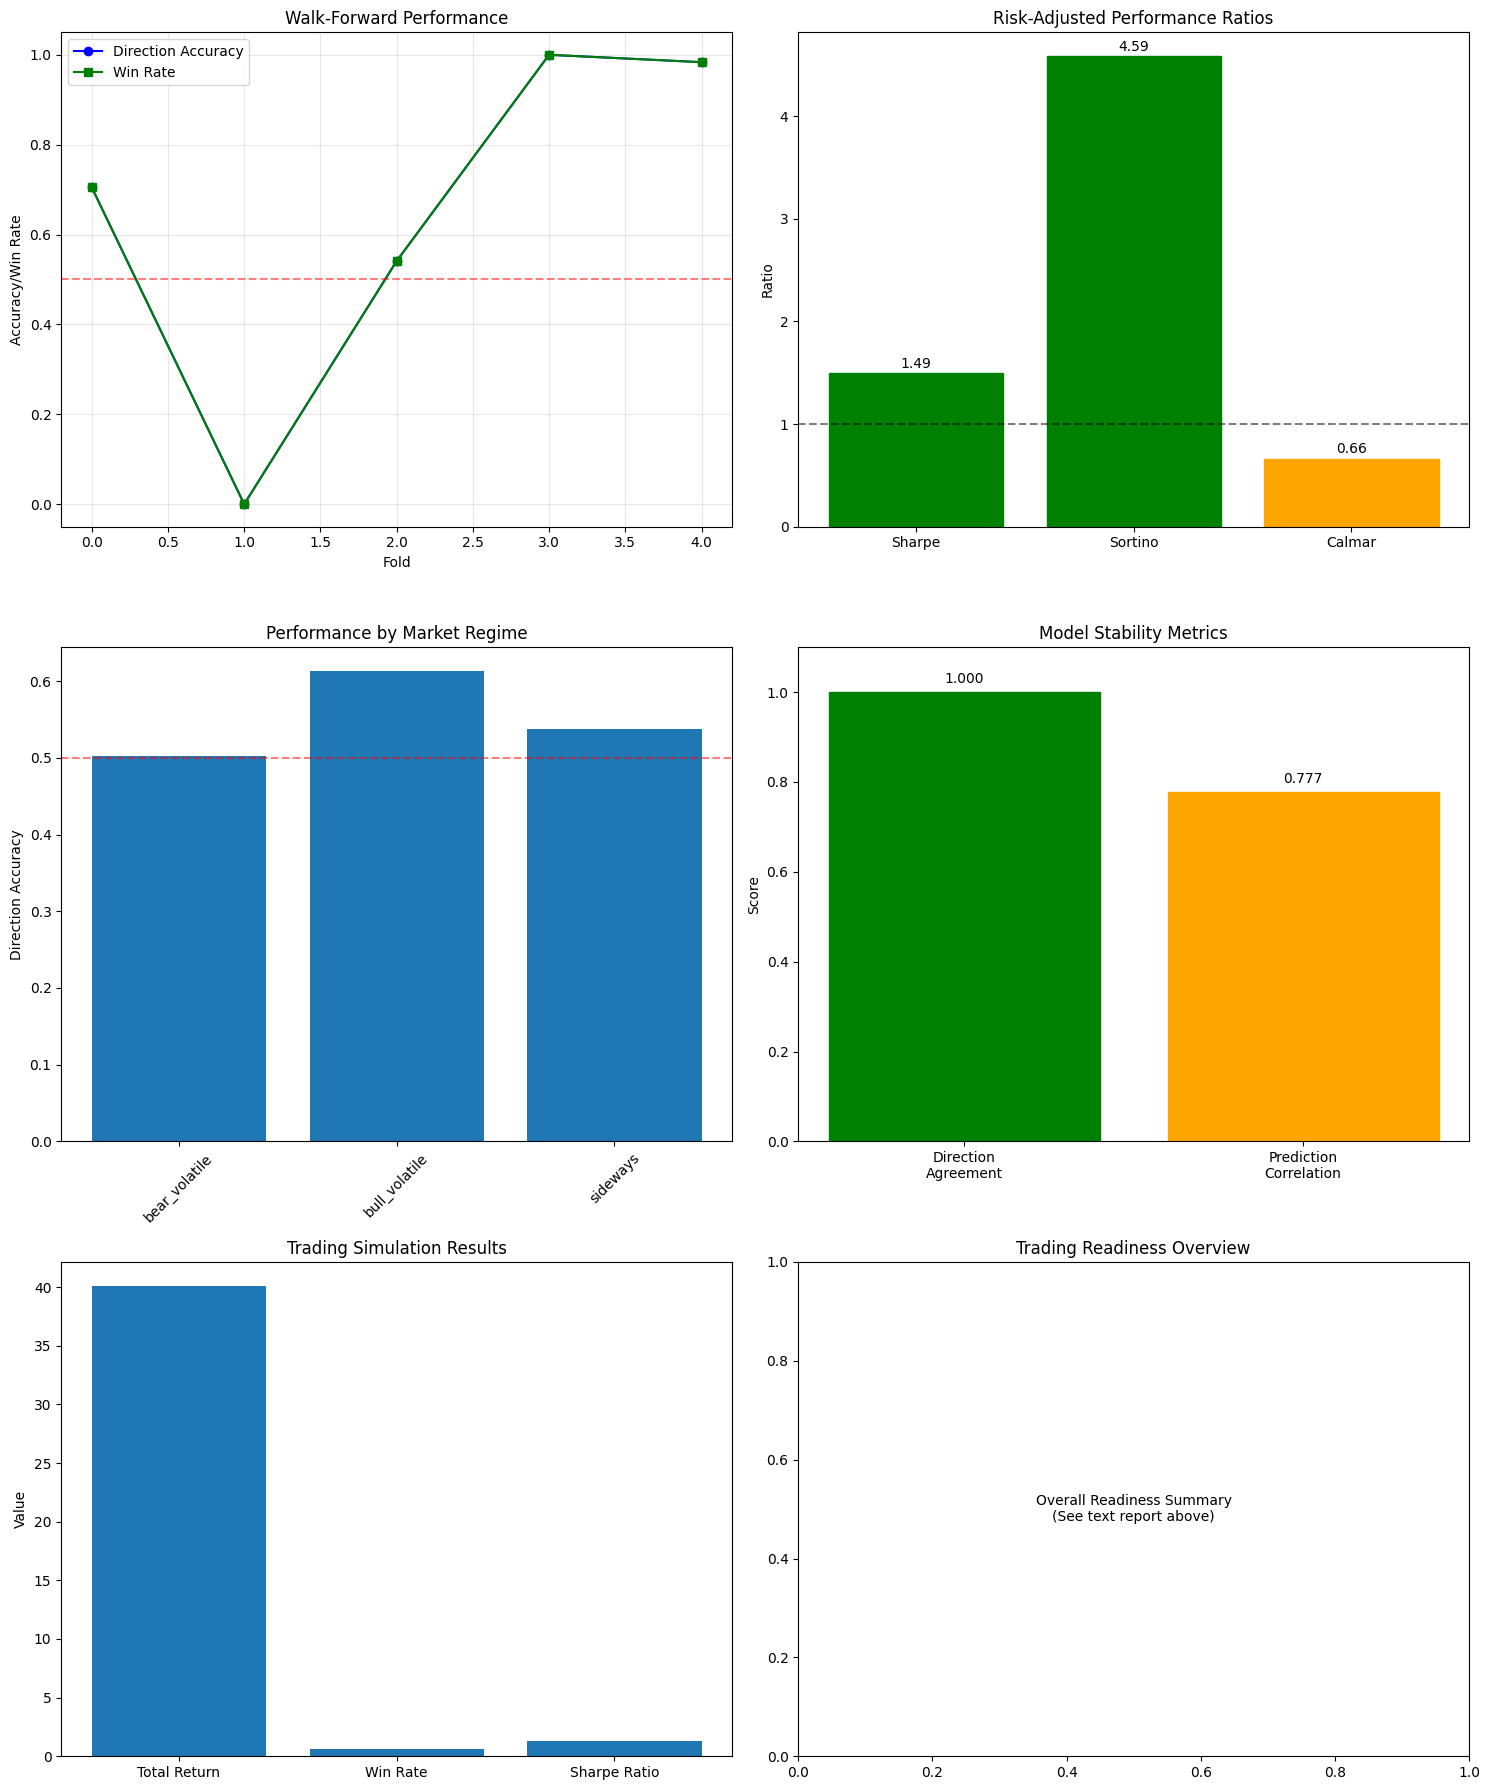

In [18]:
improved_predictor = ImprovedBitcoinPredictor(
    sequence_length=60,
    prediction_horizon=30
)
# Example usage:
tester = ComprehensiveTradingModelTester(improved_predictor)
test_results = tester.run_all_tests(df, save_report=True)
tester.plot_test_results()